In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import warnings

In [2]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

## 👇 <font color = "purple"> Bigger Question 1. 

> Here's something that's familiar to you, with a few minor tweaks.

### Please create a predictive model for the weekly return of AMZN stock. You will use supervised learning for your predictive modelling.

> As you learned in class, to do this it is essential to know what factors are related to Amazon’s stock price, and to incorporate as much information as you can into the model.

> Among the three major factors (correlated assets, technical indicators, and fundamental analysis), you will use correlated assets and technical indicators as features here.

    Step 1. Use 75% of your data for the training of your algorithm, and 25% for the testing set.

    Step 2. For your feature engineering...
    
> Our operational definition of `outcome` (`Y`) is the weekly return of Amazon (AMZN). The number of trading days in a week is assumed to be five, and we compute the return using five trading days. 
<br>
    
* <font color = "green"> NOTE: The lagged five-day variables embed the time series component by using a time-delay approach, where the lagged variable is included as one of the predictor variables. This step translates the time series data into a supervised regression-based model framework.
<br>    
    
> For `input features` (`predictors`; `Xs`), we use (The variables used as predictors are as follows) ...

> `Correlated assets`

* lagged five-day returns of stocks (AAPL, MSFT, F);
* currency exchange rates (USD/JPY and GBP/USD);
* indices (S&P 500, Dow Jones, and VIX);
* lagged five-day, 15-day, 30-day, and 60-day returns of AMZN.

> `Technical indicators`

* 21-day, 63-day, and 252-day moving averages;
* 10-day, 30-day, and 200-day exponential moving averages.

    
    Step 3. For your algorithm of choices, please assess the model performance of the following algorithms: 

* Linear Regression
* Elastic Net
* LASSO
* Support Vector Machine
* K-Nearest Neighbor
* ARIMA
* Decision Tree
* Extra Trees 
* Random Forest
* Gradient Boosting Tree
* Adaptive Boosting
    
    
    Step 4. For this exercise, hyperparameter tuning won’t be requested. 
    
    Step 5. But make sure to compare the model performance of the above algorithms.

> The metric for assessing model performance will be mean squared error (`MSE`).
<br>

> Show which of the algorithms perform relatively better by a comparison visualization of performance, for both the training and testing sets learned in class. 

    Step 6. Using the model of your choice, please visualize the actual vs. predicted (estimated) data.

### Below are the lines of code that lead to an answer:

## Step 1

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging -> Bootstrap Aggregation
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

#Step 3 fitting of algorithm
# Boosting -> Gradient Descent is an element of Gradient Boosting Regression - XGB & Random Forest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# Neural Network -> Multi-Level-Perceptron
from sklearn.neural_network import MLPRegressor

In [4]:
#Step 1 Fitting
from sklearn.model_selection import train_test_split
#Cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Grid-search for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

#Step 4&5
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

In [5]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [6]:
#EDA Tool Kits
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

## outcome & input features

In [7]:
stock_ticker = ["AAPL", "MSFT", "F", "AMZN"]
currency_ticker = ["DEXJPUS", "DEXUSUK"]
index_ticker = ["SP500", "DJIA", "VIXCLS"]

stock_data = pdr.DataReader(stock_ticker, "yahoo")
currency_data = pdr.DataReader(currency_ticker, "fred")
index_data = pdr.DataReader(index_ticker, "fred")

In [8]:
AMZN = pd.DataFrame(stock_data.loc[:, ("Adj Close", "AMZN")])
AMZN.columns = AMZN.columns.droplevel()
AMZN

,AMZN
Date,
2017-11-29,58.063499
2017-11-30,58.837502
2017-12-01,58.117500
2017-12-04,56.697498
2017-12-05,57.078499
...,...
2022-11-21,92.459999
2022-11-22,93.199997
2022-11-23,94.129997


### SMA and EMA calculations

In [9]:
AMZN["SMA_21"] = AMZN["AMZN"].rolling(window = 21).mean()
AMZN["SMA_63"] = AMZN["AMZN"].rolling(window = 63).mean()
AMZN["SMA_252"] = AMZN["AMZN"].rolling(window = 252).mean()
AMZN["EMA_10"] = AMZN["AMZN"].ewm(span = 10, adjust = False, min_periods = 10).mean()
AMZN["EMA_30"] = AMZN["AMZN"].ewm(span = 30, adjust = False, min_periods = 30).mean()
AMZN["EMA_200"] = AMZN["AMZN"].ewm(span = 200, adjust = False, min_periods = 200).mean()
AMZN

,AMZN,SMA_21,SMA_63,SMA_252,EMA_10,EMA_30,EMA_200
Date,,,,,,,
2017-11-29,58.063499,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30,58.837502,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,58.117500,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-04,56.697498,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05,57.078499,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-11-21,92.459999,99.150001,114.087937,135.177615,95.580963,102.291903,126.261639
2022-11-22,93.199997,97.882382,113.443492,134.838613,95.148060,101.705328,125.932668
2022-11-23,94.129997,96.621905,112.758572,134.501820,94.962958,101.216597,125.616223


In [10]:
AMZN

,AMZN,SMA_21,SMA_63,SMA_252,EMA_10,EMA_30,EMA_200
Date,,,,,,,
2017-11-29,58.063499,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30,58.837502,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,58.117500,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-04,56.697498,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05,57.078499,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-11-21,92.459999,99.150001,114.087937,135.177615,95.580963,102.291903,126.261639
2022-11-22,93.199997,97.882382,113.443492,134.838613,95.148060,101.705328,125.932668
2022-11-23,94.129997,96.621905,112.758572,134.501820,94.962958,101.216597,125.616223


# Defining the X and Y Variables

In [11]:
return_period = 5

## OUTCOME (Y)

In [12]:
Y = np.log(stock_data.loc[:, ("Adj Close", "AMZN")]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+"_pred"

lagged five-day, 15-day, 30-day, and 60-day returns of AMZN.

## INPUT FEATURE (X)

In [13]:
X1 = np.log(stock_data.loc[:, ("Adj Close", ("AAPL", "MSFT", "F")
                               )
                          ]
            ).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(currency_data).diff(return_period)
X3 = np.log(index_data).diff(return_period)

X4 = pd.concat([np.log(stock_data.loc[:, ("Adj Close", "AMZN")
                                     ]
                      ).diff(i) for i in [return_period, return_period * 3, return_period * 6, return_period * 12
                                         ]
               ], axis = 1
              ).dropna()

X4.columns = ["AMZN_DT", "AMZN_3DT", "AMZN_6DT", "AMZN_12DT"]

X5 = np.log(AMZN[["SMA_21","SMA_63","SMA_252","EMA_10","EMA_30","EMA_200"]]).dropna()

In [14]:
X = pd.concat([X1, X2, X3, X4, X5], axis = 1)

In [15]:
X

,AAPL,MSFT,F,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT,SMA_21,SMA_63,SMA_252,EMA_10,EMA_30,EMA_200
2017-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-22,0.000933,0.015381,-0.016215,0.013754,-0.000841,0.002964,0.014926,-0.142067,-0.059766,-0.037796,-0.185624,-0.331170,4.583767,4.731305,4.904079,4.555434,4.622080,4.835747
2022-11-23,0.015207,0.023912,0.009309,0.001217,0.012621,0.017148,0.018901,-0.169546,-0.031271,0.021585,-0.181826,-0.313040,4.570805,4.725249,4.901578,4.553487,4.617263,4.833231
2022-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.158618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-25,-0.017469,0.023756,0.012147,-0.005873,0.016664,0.015212,0.017663,-0.120273,-0.015298,0.044997,-0.186221,-0.305376,4.559779,4.719979,4.899049,4.550509,4.612274,4.830677


In [16]:
data = pd.concat([Y, X], axis = 1).dropna().iloc[ : :return_period, :]
data

,AMZN_pred,AAPL,MSFT,F,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT,SMA_21,SMA_63,SMA_252,EMA_10,EMA_30,EMA_200
2018-11-28,0.012698,0.022129,0.088485,0.037904,0.007929,-0.000783,0.034807,0.036196,-0.117723,0.115020,0.021045,-0.081361,-0.195256,4.390911,4.497420,4.385975,4.376414,4.415028,4.423170
2018-12-07,-0.023112,-0.063577,-0.049962,-0.060491,-0.008313,-0.001802,-0.047138,-0.046055,0.251191,-0.026913,0.018661,-0.021298,-0.200089,4.402721,4.481139,4.393860,4.415888,4.421648,4.423916
2018-12-17,-0.123688,-0.033942,-0.044667,-0.002350,0.000000,0.003815,-0.035415,-0.034587,0.079771,-0.076015,0.012471,-0.090834,-0.245593,4.391851,4.462409,4.400516,4.394843,4.411849,4.422195
2018-12-26,0.019777,-0.055081,-0.033348,-0.076017,-0.015274,0.000552,-0.015784,-0.019273,0.172961,-0.053335,-0.186438,-0.152039,-0.308772,4.375818,4.435164,4.404457,4.312074,4.370294,4.414600
2019-01-04,0.040535,-0.051850,0.007385,0.028878,-0.018754,0.003223,0.018415,0.015949,-0.281818,0.074944,-0.054445,0.040878,-0.168447,4.347874,4.407863,4.409172,4.325410,4.355971,4.409549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-12,0.019038,-0.056628,-0.098828,-0.080709,0.014678,-0.016003,-0.056059,-0.035745,0.161976,-0.068875,-0.048748,-0.131215,-0.045960,4.772205,4.845268,4.962136,4.750986,4.791401,4.898003
2022-10-20,-0.037934,0.002793,0.008121,0.000000,0.017982,-0.004949,-0.001126,0.009768,-0.063329,0.023884,0.003912,-0.119045,-0.048439,4.746141,4.840833,4.952788,4.740450,4.772251,4.888981
2022-10-27,-0.217168,0.009785,-0.040619,0.099395,-0.025691,0.025021,0.037879,0.054520,-0.090353,-0.037934,-0.080819,-0.129332,-0.229038,4.749320,4.837342,4.945569,4.750903,4.769372,4.883240
2022-11-03,0.078888,-0.041743,-0.056705,0.019803,0.014684,-0.034366,-0.023226,-0.001000,-0.079374,-0.217168,-0.231218,-0.272818,-0.468673,4.706505,4.810769,4.935420,4.632441,4.716133,4.870109


### Exploratory Data Analysis (EDA)

In [17]:
Y = data.loc[:, Y.name]
X = data.loc[:, X.columns]

In [18]:
data.describe()

,AMZN_pred,AAPL,MSFT,F,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT,SMA_21,SMA_63,SMA_252,EMA_10,EMA_30,EMA_200
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.000444,0.006541,0.005035,0.001339,0.001240,-0.000747,0.002049,0.001514,-0.001176,0.000933,0.004897,0.009287,0.016449,4.825269,4.820424,4.787456,4.826002,4.824547,4.793396
std,0.052438,0.041585,0.040955,0.062707,0.010700,0.015252,0.029785,0.030105,0.163796,0.051354,0.087432,0.114583,0.156685,0.271230,0.270471,0.272454,0.270871,0.269177,0.264947
min,-0.217168,-0.165544,-0.178708,-0.230963,-0.044151,-0.072668,-0.198044,-0.208720,-0.495296,-0.217168,-0.327031,-0.441620,-0.468673,4.345752,4.383977,4.385975,4.312074,4.355971,4.408777
25%,-0.024088,-0.014724,-0.014677,-0.030406,-0.004475,-0.008098,-0.009920,-0.009056,-0.076907,-0.021898,-0.042543,-0.043645,-0.045098,4.540759,4.538621,4.490196,4.541966,4.537356,4.497796
50%,0.002674,0.010157,0.007856,0.003906,0.001087,-0.001333,0.005304,0.003560,-0.008840,0.003993,0.009631,0.006307,0.026259,4.864323,4.842201,4.837493,4.873895,4.858972,4.897719
75%,0.029718,0.031172,0.027390,0.037096,0.007150,0.006378,0.017995,0.014418,0.070053,0.029215,0.054046,0.078744,0.082035,5.081131,5.076717,5.070008,5.083226,5.075347,5.043435
max,0.150696,0.137438,0.125836,0.208356,0.040886,0.062456,0.098984,0.115749,0.922952,0.115020,0.230896,0.301265,0.449371,5.194417,5.154450,5.120472,5.201420,5.180208,5.122947


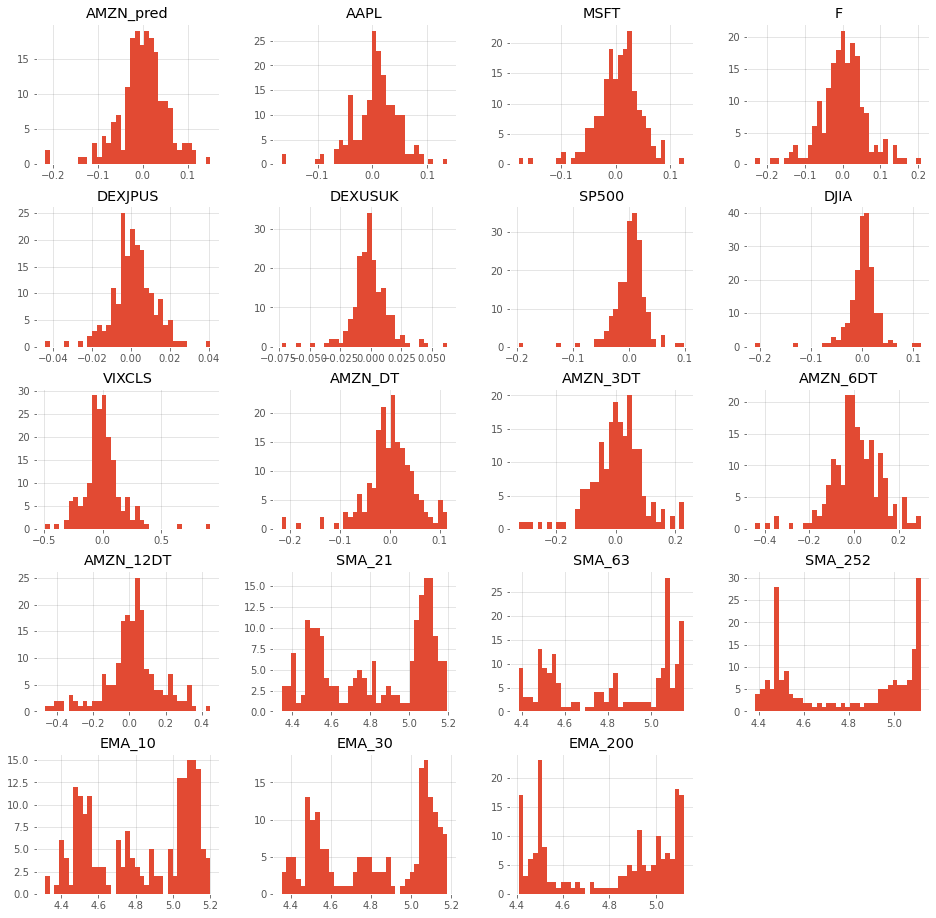

In [19]:
data.hist(bins = 35,
          sharex = False,
          sharey = False,
          figsize = (16, 16)
         )
plt.show()

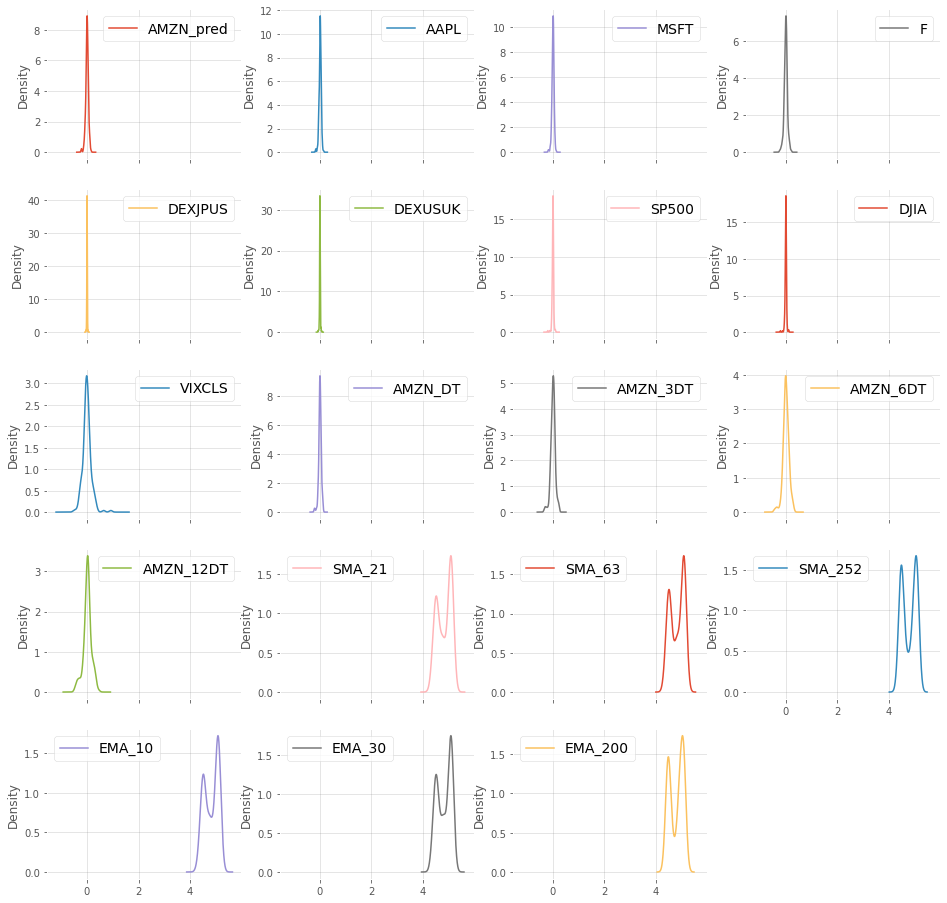

In [20]:
data.plot(kind = "density",
          subplots = True,
          layout = (5,4),
          sharex = True,
          legend = True,
          figsize = (16, 16)
         )
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

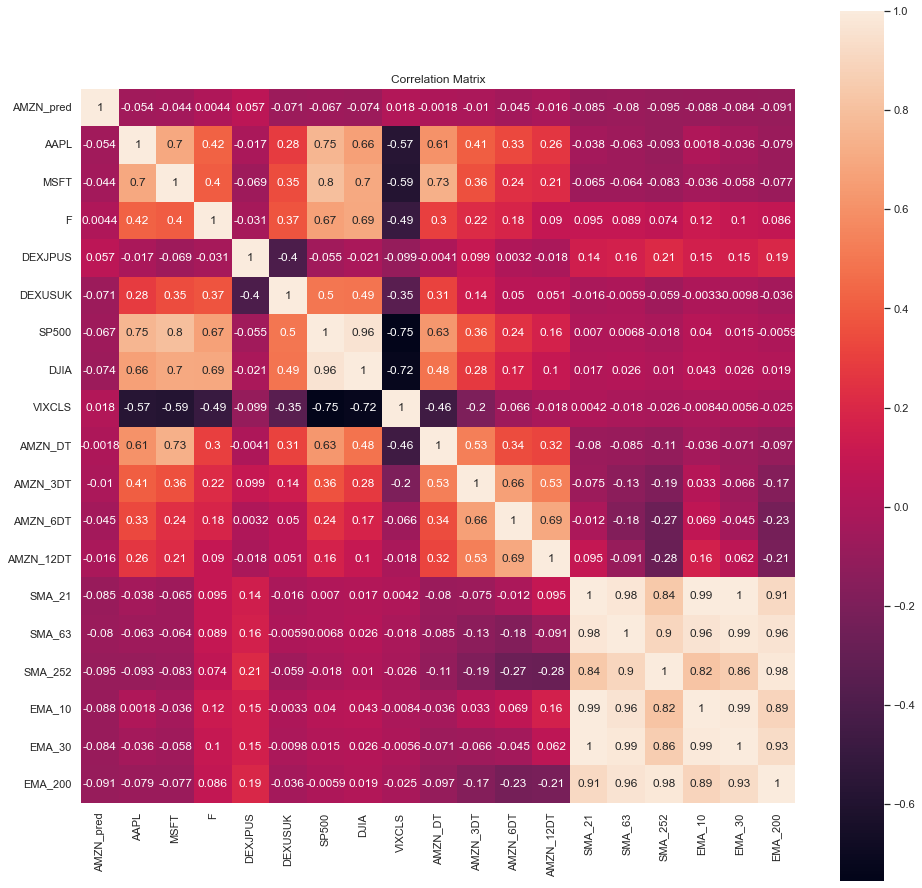

In [21]:
sns.set_theme(style = "white")

correlation = data.corr()

plt.figure(figsize = (16, 16)
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            annot = True,
            cmap = "rocket")

### Setting the model criteria and visualising the results

In [22]:
validation_size = 0.25

train_size = int(len(X) * (1 - validation_size)
                 )

X_train, X_test = X[0:train_size], X[train_size:len(X)]

Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [23]:
num_folds = 10
seed = 7
scoring = "neg_mean_squared_error"

In [24]:
models = []

In [25]:
models.append(("LR", LinearRegression()
              )
             )

models.append(("LASSO", Lasso()
              )
             )
    
models.append(("EN", ElasticNet()
              )
             )

models.append(("CART", DecisionTreeRegressor()
              )
             )

models.append(("KNN", KNeighborsRegressor()
              )
             )

models.append(("SVR", SVR()
              )
             )

In [26]:
# Bagging

models.append(("ETR", ExtraTreesRegressor()
              )
             )

models.append(("RFR", RandomForestRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [27]:
import warnings

In [28]:
warnings.filterwarnings("ignore")

# warnings.filterwarnings(action = "once")

In [29]:
names = []

kfold_results = []

train_results = []
test_results = []

for name, model in models:
    names.append(name)
    
    # Let's run K-Fold analysis
    
    kfold = KFold(n_splits = num_folds,
                  random_state = seed,
                  shuffle = True)
    
    # Let's convert MSE to positive (HERE, the lower the better)
    
    cv_results = -1 * cross_val_score(model, X_train, Y_train,
                                      cv = kfold,
                                      scoring = scoring)
    
    kfold_results.append(cv_results) # REMEMBER TO ADD THIS
    
    # Entire training period
    
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Results for test
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(message)

LR: 0.001984 (0.001073) 0.001533 0.006956
LASSO: 0.001826 (0.000987) 0.001781 0.005671
EN: 0.001826 (0.000987) 0.001781 0.005671
CART: 0.003465 (0.001388) 0.000000 0.009062
KNN: 0.001838 (0.000996) 0.001230 0.006308
SVR: 0.002029 (0.001289) 0.001805 0.005946
ETR: 0.002082 (0.001192) 0.000000 0.006333
RFR: 0.002018 (0.001191) 0.000267 0.006813
GBR: 0.002182 (0.001299) 0.000104 0.007239
ABR: 0.002060 (0.001166) 0.000803 0.006381


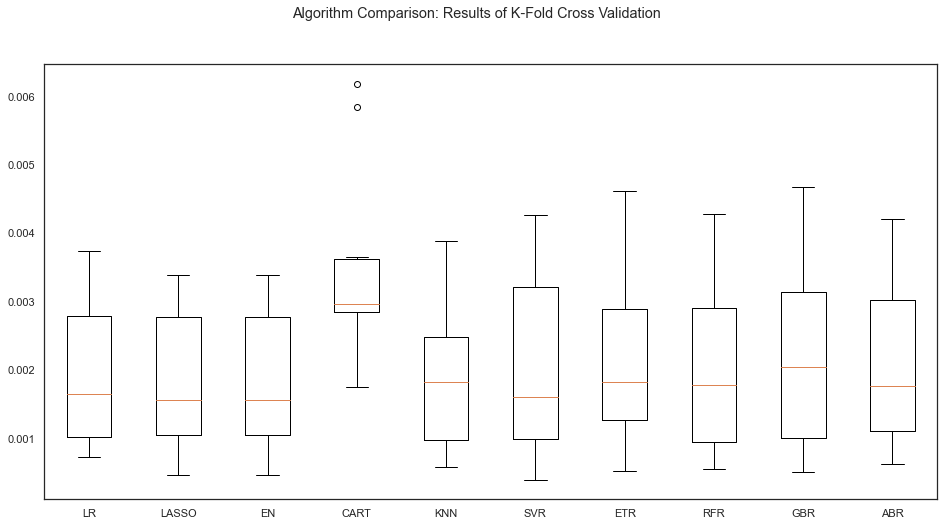

In [30]:
fig = plt.figure(figsize = (16, 8)
                 )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

## Arima Model

In [31]:
X_train_ARIMA = X_train.loc[:, ["AAPL", "MSFT", "F", "DEXJPUS", "DEXUSUK", "SP500", "DJIA", "VIXCLS", 'AMZN_DT', 'AMZN_3DT', 'AMZN_6DT', 'AMZN_12DT', 'SMA_21',
       'SMA_63', 'SMA_252', 'EMA_10', 'EMA_30', 'EMA_200']
                            ]

X_test_ARIMA = X_test.loc[:, ["AAPL", "MSFT", "F", "DEXJPUS", "DEXUSUK", "SP500", "DJIA", "VIXCLS", 'AMZN_DT', 'AMZN_3DT', 'AMZN_6DT', 'AMZN_12DT', 'SMA_21',
       'SMA_63', 'SMA_252', 'EMA_10', 'EMA_30', 'EMA_200']
                          ]

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)

In [32]:
modelARIMA = stats.ARIMA(endog= Y_train, exog = X_train_ARIMA, order = [1, 0, 0]
                         )

model_fit = modelARIMA.fit()

In [33]:
error_Training_ARIMA = mean_squared_error(Y_train,
                                          model_fit.fittedvalues)

predicted = model_fit.predict(start = train_len -1, 
                              end = total_len - 1, 
                              exog = X_test_ARIMA)[1:]

error_Test_ARIMA = mean_squared_error(Y_test,
                                      predicted)

error_Test_ARIMA

0.00696258820470946

In [34]:
test_results.append(error_Test_ARIMA)

train_results.append(error_Training_ARIMA)

names.append("ARIMA")

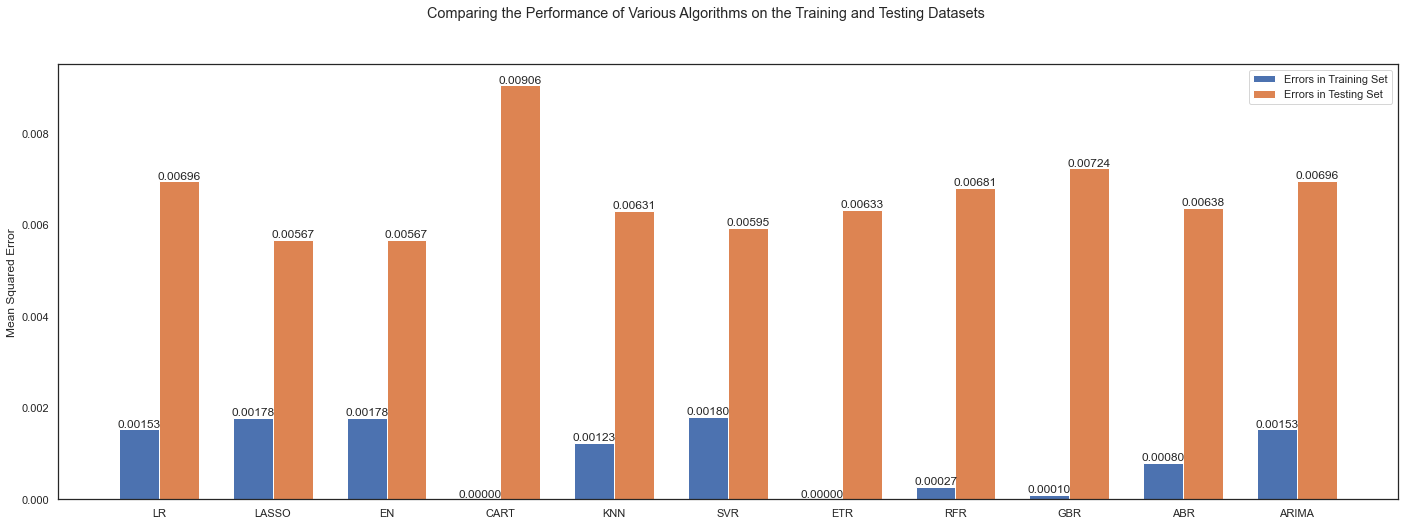

In [35]:
fig = plt.figure(figsize = (24, 8)
                 )

ind = np.arange(len(names)
               ) 
width = 0.35

fig.suptitle("Comparing the Performance of Various Algorithms on the Training and Testing Datasets")
ax = fig.add_subplot(111)

bar1 = plt.bar(ind - width/2, 
        train_results, 
        width = width,
        label = "Errors in Training Set")

bar2 = plt.bar(ind + width/2, 
        test_results, 
        width = width,
        label = "Errors in Testing Set")

ax.bar_label(bar1, fmt='%.5f')
ax.bar_label(bar2, fmt='%.5f')

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error")

plt.show()

# <font color = 'red'> Hyperparameter tuning: ARIMA, LASSO, EN, SVM </font>

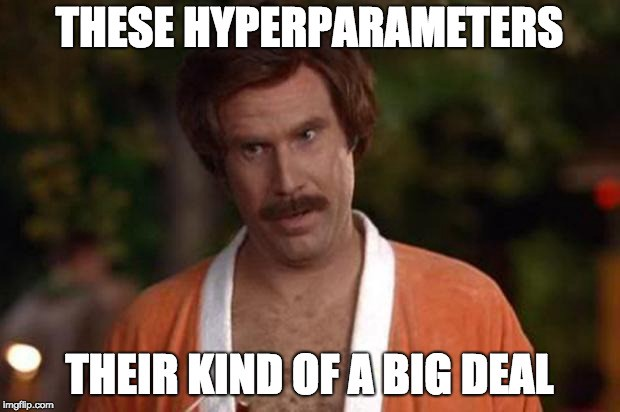

In [36]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_ARIMA_model(arima_order):
    
    modelARIMA = stats.ARIMA(endog = Y_train, 
                             exog = X_train_ARIMA,
                             order = arima_order)
    
    model_fit = modelARIMA.fit()
    
    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    
    return error

def assess_models(p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    
                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )
                    
                except:
                    continue
    print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
          )
    
# parameters to use for assessment

p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 5)

In [37]:
assess_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE = 0.0015329
ARIMA(0, 0, 1) MSE = 0.0015327
ARIMA(0, 0, 2) MSE = 0.0015070
ARIMA(0, 0, 3) MSE = 0.0015080
ARIMA(0, 0, 4) MSE = 0.0015035
ARIMA(0, 1, 0) MSE = 0.0451017
ARIMA(0, 1, 1) MSE = 0.0088837
ARIMA(0, 1, 2) MSE = 0.0093702
ARIMA(0, 1, 3) MSE = 0.0086000
ARIMA(0, 1, 4) MSE = 0.0092037
ARIMA(1, 0, 0) MSE = 0.0015326
ARIMA(1, 0, 1) MSE = 0.0022672
ARIMA(1, 0, 2) MSE = 0.0015075
ARIMA(1, 0, 3) MSE = 0.0015096
ARIMA(1, 0, 4) MSE = 0.0014820
ARIMA(1, 1, 0) MSE = 0.0371959
ARIMA(1, 1, 1) MSE = 0.0081284
ARIMA(1, 1, 2) MSE = 0.0111815
ARIMA(1, 1, 3) MSE = 0.0130132
ARIMA(1, 1, 4) MSE = 0.0158917
ARIMA(2, 0, 0) MSE = 0.0015081
ARIMA(2, 0, 1) MSE = 0.0015378
ARIMA(2, 0, 2) MSE = 0.0015061
ARIMA(2, 0, 3) MSE = 0.0014601
ARIMA(2, 0, 4) MSE = 0.0014795
ARIMA(2, 1, 0) MSE = 0.0168118
ARIMA(2, 1, 1) MSE = 0.0190543
ARIMA(2, 1, 2) MSE = 0.0207392
ARIMA(2, 1, 3) MSE = 0.0105459
ARIMA(2, 1, 4) MSE = 0.0133738
ARIMA(3, 0, 0) MSE = 0.0014940
ARIMA(3, 0, 1) MSE = 0.0014956
ARIMA(3,

In [38]:
ARIMA_Tuned = stats.ARIMA(endog = Y_train,
                          exog = X_train_ARIMA,
                          order = [3, 0, 2]
                          )

ARIMA_Fit_Tuned = ARIMA_Tuned.fit()

In [39]:
Predicted_Tuned = model_fit.predict(start = train_len - 1, 
                                    end = total_len - 1,
                                    exog = X_test_ARIMA)[1:]

In [40]:
print(mean_squared_error(Y_test,
                         Predicted_Tuned)
     )

0.00696258820470946


In [41]:
# plt.figure(figsize = (16, 10)
#            )
# plt.grid()
# Predicted_Tuned.index = Y_test.index

# plt.plot(np.exp(Y_test).cumprod(), "b--", label = "Actual Y")

# plt.plot(np.exp(Predicted_Tuned).cumprod(), "r", label = "Predicted Y (Y hat)")

# plt.show()

In [42]:
error_Training_ARIMA_Tuned = mean_squared_error(Y_train,
                                          ARIMA_Fit_Tuned.fittedvalues)

error_Test_ARIMA_Tuned = mean_squared_error(Y_test,
                                      Predicted_Tuned)

In [43]:
test_results.append(error_Test_ARIMA)

train_results.append(error_Training_ARIMA)

names.append("ARIMA_Tuned")

# LASSO tuning

In [147]:
grid

{'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99])}

In [146]:
model1 = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=3)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model1, grid, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, Y_train)
# summarize
print('Config: %s' % results.best_params_)

/Users/daoduyhung/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/daoduyhung/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/daoduyhung/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/daoduyhung/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of 

Config: {'alpha': 0.01}


In [45]:
lasso_tuned=Lasso(0.01)
lasso_tuned_fit=lasso_tuned.fit(X_train,Y_train)

In [46]:
y_pred2=lasso_tuned_fit.predict(X_test)
error_test_lasso=mean_squared_error(Y_test,y_pred2)
error_test_lasso

0.0056712448196031915

In [47]:
y_pred_usingtrainLasso=lasso_tuned_fit.predict(X_train)
error_train_Lasso=mean_squared_error(Y_train,y_pred_usingtrainLasso)
error_train_Lasso

0.0017807187955694655

In [48]:
test_results.append(error_test_lasso)

train_results.append(error_train_Lasso)

names.append("Lasso_Tuned")

In [ ]:
gala

# Support Vector Regression Tuning

In [137]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid

{'C': [0.1, 1, 10, 100],
 'gamma': [1, 0.1, 0.01, 0.001],
 'kernel': ['rbf', 'poly', 'sigmoid']}

In [138]:
gridS = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
gridS.fit(X_train,Y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [139]:
print(grid.best_estimator_)

SVR(C=1, gamma=0.01, kernel='sigmoid')


In [140]:
SVR_tuned=SVR(kernel='sigmoid',gamma=0.01,C=1)
# SVR(C=1, gamma=0.01, kernel='sigmoid')
SVR_tuned_fit=SVR_tuned.fit(X_train,Y_train)
SVR_tuned_fit

SVR(C=1, gamma=0.01, kernel='sigmoid')

In [141]:
y_pred=SVR_tuned_fit.predict(X_test)

In [142]:
error_test_SVRT=mean_squared_error(Y_test,y_pred)
error_test_SVRT

0.005713992412634828

In [143]:
y_pred_usingtrainSVR =SVR_tuned_fit.predict(X_train)
error_train_SVRT =mean_squared_error(Y_train,y_pred_usingtrainSVR)
error_train_SVRT

0.0017812665809991972

In [144]:
test_results.append(error_test_SVRT)

train_results.append(error_train_SVRT)

names.append("SVR_Tuned")

In [145]:
gridS

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

# Elastic Net tuning

In [57]:
parametersGrid = {"max_iter": [10, 50, 100],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}
eNet = ElasticNet()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=cv)
grid.fit(X_train, Y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [10, 50, 100]},
             scoring='neg_mean_squared_error')

In [58]:
print(grid2.best_estimator_)

ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=10)


In [59]:
EN_tuned=ElasticNet(alpha=0.01,l1_ratio=0.2,max_iter=10)
EN_tuned_fit=EN_tuned.fit(X_train,Y_train)
EN_tuned_fit


ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=10)

In [60]:
y_pred3=EN_tuned_fit.predict(X_test)
error_test_EN=mean_squared_error(Y_test,y_pred3)
error_test_EN

0.0056712448196031915

In [61]:
y_pred_usingtrain=EN_tuned_fit.predict(X_train)
error_train_EN=mean_squared_error(Y_train,y_pred_usingtrain)
error_train_EN

0.0017807187955694655

In [62]:
test_results.append(error_test_EN)

train_results.append(error_train_EN)

names.append("EN_Tuned")

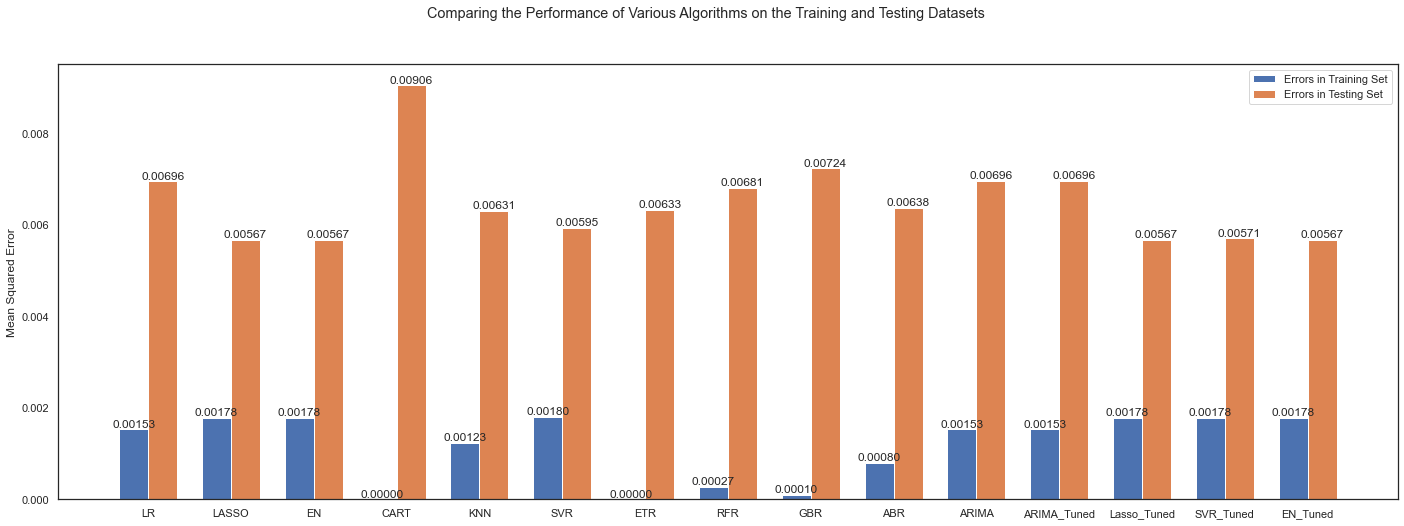

In [63]:
fig = plt.figure(figsize = (24, 8)
                 )

ind = np.arange(len(names)
               ) 
width = 0.35

fig.suptitle("Comparing the Performance of Various Algorithms on the Training and Testing Datasets")
ax = fig.add_subplot(111)

bar1 = plt.bar(ind - width/2, 
        train_results, 
        width = width,
        label = "Errors in Training Set")

bar2 = plt.bar(ind + width/2, 
        test_results, 
        width = width,
        label = "Errors in Testing Set")

ax.bar_label(bar1, fmt='%.5f')
ax.bar_label(bar2, fmt='%.5f')

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error")

plt.show()

In [64]:
#######
train_results_pd = pd.DataFrame(train_results)
test_results_pd = pd.DataFrame(test_results)
per_MSE = (test_results_pd - train_results_pd)/train_results_pd
per_MSE = pd.DataFrame(per_MSE)
per_MSE.columns = ['Relative Error of Testing to Training Set']
per_MSE['Names'] = names
per_MSE = per_MSE.set_index('Names')
per_MSE

,Relative Error of Testing to Training Set
Names,
LR,3.538046e+00
LASSO,2.184807e+00
EN,2.184807e+00
CART,inf
KNN,4.127823e+00
SVR,2.295206e+00
ETR,3.224087e+30
RFR,2.451985e+01
GBR,6.832859e+01


### <font color = red> Answer 1 is presented in the cell below: </font>

In [65]:
per_MSE[per_MSE['Relative Error of Testing to Training Set'] == per_MSE['Relative Error of Testing to Training Set'].min()]

,Relative Error of Testing to Training Set
Names,
LASSO,2.184807
EN,2.184807
Lasso_Tuned,2.184807
EN_Tuned,2.184807


![display image](https://i.imgflip.com/6x6u5v.jpg)

 ###   Step 6. Using the model of your choice, please visualize the actual vs. predicted (estimated) data.

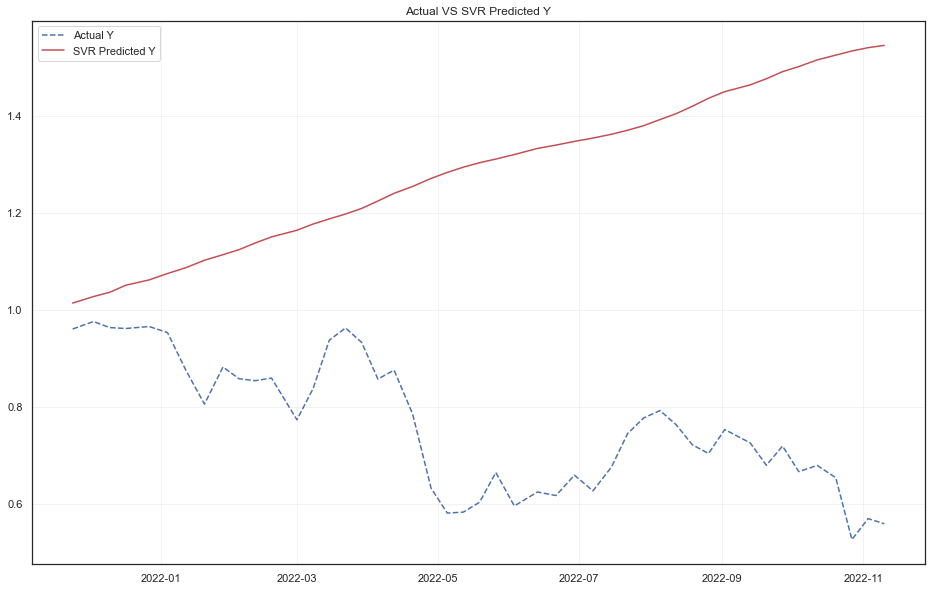

In [66]:
SVR_Y_hat = (SVR().fit(X_train, Y_train)).predict(X_test)
SVR_Y_hat = pd.DataFrame(SVR_Y_hat, index = Y_test.index)

plt.figure(figsize = (16, 10)
           )
plt.grid()

plt.plot(np.exp(Y_test).cumprod(), "b--", label = "Actual Y")

plt.plot(np.exp(SVR_Y_hat).cumprod(), "r", label = "SVR Predicted Y")
plt.title("Actual VS SVR Predicted Y")
plt.legend()
plt.show()

## <font color = blue> 👉 Questions 2 to 5 ask you to build, execute, and backtest a trend-following (momentum-based) strategy, using `Relative Strength Index` (`RSI`). </font>

#### The Relative Strength Index (RSI) is an indicator that uses the closing prices of an asset to identify oversold and overbought conditions. 

> Most commonly, RSI is calculated using a 14-day period, and measured on a scale from zero to 100. (It is an oscillator.)

> Traders usually buy an asset when it is oversold (when its RSI is below 30) and sell when it is overbought (when its RSI is above 70). 

> More extreme overbought and oversold levels, such as 80 and 20, are used less frequently, and imply stronger momentum.

#### You are asked to build a trading strategy with the following set of rules.

### <font color = green> NOTE: Apple (`AAPL`) as our security of interest. The `investment horizon` will be three years between 2015 and 2017; your `capital` is USD 100,000; and there is a USD 5 flat `commission fee` per trade.

- You can go long and short.
<br>

- To calculate RSI, use 14 periods (trading days).
<br>

- Enter a long position if RSI crosses the lower threshold (standard value of 30), moving upwards. Exit the position when RSI becomes higher than the middle level (value of 50).
<br>

- Enter a short position if RSI crosses the upper threshold (standard value of 70), moving downwards. Exit the position when RSI becomes less than 50.
<br>

- Only one position can be open at a time.

### <font color = green> NOTE: The RSI is defined as follows:
    
### Calculating the RSI first requires the RS which requires an average value of n-many previous trading days. 
<br>
    
- As discussed, a value of 14 days is common for the RSI calculation. 
<br>
    
- The first RS value requires the price from all 14 of the first trading days. Often, this is a source of confusion with the RSI given successive values only require the most recent. 
   
    
    Step 1. For 14 periods, calculate the difference in price from the current period and the previous period
    
    Step 2. For each period, record each positive change in price as a gain and each negative change as a loss
    
    Step 3. On the 14th period, calculate the arithmetic mean of the gains and losses for the entire 14 day period (e.g. gains / 14 & losses / 14)
    
    Step 4. Use these values to calculate the RS
    
### <center> $ RS = \frac{AverageGain}{AverageLoss} $
    
    Step 5. Use the RS value to calculate the RSI
    
    Step 6. For each proceeding period, use only the previous RSI value to calculate the next average value 
    by multiplying by our lookback period – 1 (e.g., 13 for a lookback of 14).
    
    Step 7. Add the value obtained in Step 6 to the current day’s value (run this for both the gains and losses)
    
### <center> $ RSI = 100 - \frac{100}{1 + RS} $

### Visualize your buy and sell positions.

### Below are the lines of code that lead to an answer:

In [67]:
pd.set_option('display.max_rows',50)

In [68]:
def RSIPlot(RSIdf,Overbought,Oversold,Closing):
    
    RSIdf[["Hodling Returns", "Strategy Cumulative Returns"]].dropna().plot(figsize=(16,8)) 
    plt.ylabel("Cumulative Returns") 
    plt.title("RSI Strategy vs Hodling Returns")
    
    plt.figure(figsize=(15,6))
    plt.plot(RSIdf.index, RSIdf['RSI'],color='black', alpha = 0.3)
    plt.axhline(Overbought ,color = 'red')
    plt.axhline(Oversold ,color='green')
    plt.axhline(Closing , linestyle = "dotted", color = 'black')
    plt.scatter(RSIdf[RSIdf['Signal'] == 1].index , RSIdf[RSIdf['Signal'] == 1]["RSI"],marker = '^', color = 'green', label = 'Long Signal')
    plt.scatter(RSIdf[RSIdf['Signal'] == -1].index , RSIdf[RSIdf['Signal'] == -1]["RSI"],marker = 'v', color = 'red', label = 'Short Signal')
    plt.title('RSI')
    plt.legend(loc='upper left')
    plt.show()

    plt.figure(figsize=(15,6))
    plt.plot(RSIdf.index, RSIdf['RSI'],label='RSI',color='black', alpha = 0.3)
    plt.axhline(Overbought ,color = 'red')
    plt.axhline(Oversold ,color='green')
    plt.axhline(Closing ,linestyle = "dotted", color = 'black')
    plt.scatter(RSIdf[RSIdf['Execution'] == 1].index , RSIdf[RSIdf['Execution'] == 1]["RSI"],marker = '*', color = 'Purple', label = 'Execution')
    plt.scatter(RSIdf[RSIdf['Closing'] == 1].index , RSIdf[RSIdf['Closing'] == 1]["RSI"],marker = 'D', color = 'Orange', label = 'Closing')
    plt.title('RSI')
    plt.legend(loc='upper left')
    plt.show()

In [69]:
def RSIBacktester(Ticker, Start = '2015-01-01', End = '2017-12-31', Overbought = 70, Oversold = 30, Closing = 50, Capital = 100000, Trading_Fee = 5):
    
    ## PARSE STOCK DATA FROM YAHOO FINANCE
    RSIdf = yf.download(Ticker ,start = Start, end = End)
    RSIdf = pd.DataFrame(RSIdf['Adj Close'])
    
    ## RSI CALCULATION
    RSIdf['Daily Change'] = RSIdf['Adj Close'].diff()

    RSIperiod = 14 ## lookback window

    RSIdf['Up']= [x if x > 0 else 0 for x in RSIdf['Daily Change']]
    RSIdf['Down']= [abs(x) if x < 0 else 0 for x in RSIdf['Daily Change']]
    
    RSIdf['Up']= RSIdf['Up'].ewm(span = RSIperiod, min_periods = RSIperiod - 1).mean()
    RSIdf['Down']= RSIdf['Down'].ewm(span = RSIperiod, min_periods = RSIperiod - 1).mean()
    
    #.ewm Variation from PyDay: .ewm(com = RSIperiod - 1, adjust = False).mean()
    #com Param Specifies decay in terms of center of mass
    #Alpha = 1/(1 + Com) for Com >= 0 -> This is different from Span's Alpha = 2/(1 + Com) for Span >= 1
    #adjust = False Param calculates the exponentially weighted function recursively:
    #Yt = (1 - Alpha)*Yt-1 + Alpha*Xt
    
    RSIdf['RS']= RSIdf['Up']/RSIdf['Down']
    RSIdf['RSI']=100-(100/( 1 + RSIdf['RS']))
    
    ## SETUP/RESET NECESSARY COLUMNS FOR STRATEGY EXECUTION
    RSIdf['Yesterday RSI'] = RSIdf['RSI'].shift(1)
    RSIdf["Signal"] = 0
    RSIdf["Position"] = 0
    RSIdf["Execution"] = 0
    RSIdf["Closing"] = 0
    RSIdf["Capital"] = Capital
    RSIdf["Cash"] = Capital
    RSIdf["Stock_Holding"] = 0
    RSIdf["Daily_Stock_Value"] = 0

    for i in range(len(RSIdf)): 
        
        ##SIGNAL GENERATION
        if RSIdf["Yesterday RSI"][i] < Oversold and RSIdf['RSI'][i] > Oversold and  RSIdf['RSI'][i] < Closing and RSIdf["RSI"][i] > RSIdf["Yesterday RSI"][i]: 
            RSIdf["Signal"][i] = 1  
        elif RSIdf["Yesterday RSI"][i] > Overbought and RSIdf['RSI'][i] < Overbought and  RSIdf['RSI'][i] > Closing and RSIdf["RSI"][i] < RSIdf["Yesterday RSI"][i]: 
            RSIdf["Signal"][i] = -1  
        else: 
            RSIdf["Signal"][i] = 0

        ##SIGNAL EXECUTION CHECK
        if RSIdf["Position"][i] == 0 and abs(RSIdf['Signal'])[i] == 1: #Execute Signals only when Position = 0 
            RSIdf["Position"][i:] = RSIdf['Signal'][i]

            if RSIdf["Position"][i] == 1: #Execute Long Trade
                RSIdf["Stock_Holding"][i:] = int(0.8 * ((RSIdf["Cash"][i]- Trading_Fee)/RSIdf["Adj Close"][i]))
                RSIdf["Daily_Stock_Value"][i:] = RSIdf["Adj Close"][i] * RSIdf["Stock_Holding"][i]
                RSIdf["Cash"][i:] = RSIdf["Cash"][i] - RSIdf["Daily_Stock_Value"][i] - Trading_Fee
                RSIdf["Capital"][i:] = RSIdf["Cash"][i] + RSIdf["Daily_Stock_Value"][i]
                RSIdf["Execution"][i] = 1

            elif RSIdf["Position"][i] == -1: #Execute Short Trade
                RSIdf["Stock_Holding"][i:] = -int(0.8 * ((RSIdf["Cash"][i]- Trading_Fee)/RSIdf["Adj Close"][i]))
                RSIdf["Daily_Stock_Value"][i:] = RSIdf["Adj Close"][i] * RSIdf["Stock_Holding"][i]
                RSIdf["Cash"][i:] = RSIdf["Cash"][i] + abs(RSIdf["Daily_Stock_Value"][i]) - Trading_Fee
                RSIdf["Capital"][i:] = RSIdf["Cash"][i] + RSIdf["Daily_Stock_Value"][i]
                RSIdf["Execution"][i] = 1
        else:
            RSIdf["Daily_Stock_Value"][i:] = RSIdf["Adj Close"][i] * RSIdf["Stock_Holding"][i]
            RSIdf["Capital"][i:] = RSIdf["Cash"][i] + RSIdf["Daily_Stock_Value"][i]

        ##TRADE CLOSING CHECK
        if RSIdf["Position"][i] == 1 and RSIdf['RSI'][i] > 50: #Close Long Position
            RSIdf["Cash"][i:] = RSIdf["Cash"][i] + RSIdf["Daily_Stock_Value"][i] - Trading_Fee
            RSIdf["Daily_Stock_Value"][i:] = 0
            RSIdf["Stock_Holding"][i:] = 0
            RSIdf["Position"][i:] = 0
            RSIdf["Capital"][i:] = RSIdf["Cash"][i] 
            RSIdf["Closing"][i] = 1

        elif RSIdf["Position"][i] == -1 and RSIdf['RSI'][i] < 50: #Close Short Position
            RSIdf["Cash"][i:] = RSIdf["Cash"][i] + RSIdf["Daily_Stock_Value"][i] - Trading_Fee
            RSIdf["Daily_Stock_Value"][i:] = 0
            RSIdf["Stock_Holding"][i:] = 0
            RSIdf["Position"][i:] = 0
            RSIdf["Capital"][i:] = RSIdf["Cash"][i] 
            RSIdf["Closing"][i] = 1
        else: 
            RSIdf["Daily_Stock_Value"][i:] = RSIdf["Adj Close"][i] * RSIdf["Stock_Holding"][i]
            RSIdf["Capital"][i:] = RSIdf["Cash"][i] + RSIdf["Daily_Stock_Value"][i]
    
    RSIdf['Return'] = np.log(RSIdf['Capital']/RSIdf['Capital'].shift(1))
    RSIdf['Strategy Cumulative Returns'] = np.exp(RSIdf['Return'].cumsum())-1
    RSIdf['Hodling Returns'] = np.exp(np.log(RSIdf['Adj Close']/RSIdf['Adj Close'].shift(1)).cumsum()) - 1
    RSIdf['Max Gross Performance'] = RSIdf['Strategy Cumulative Returns'].cummax()
    RSIdf['Drawdown'] = RSIdf['Max Gross Performance'] - RSIdf["Strategy Cumulative Returns"]
    
    ##PLOT RSI TEST RESULTS
    RSIPlot(RSIdf,Overbought,Oversold,Closing)
    
    return RSIdf

### <font color = red> Answer 2 is presented in the cell below: </font>

[*********************100%***********************]  1 of 1 completed


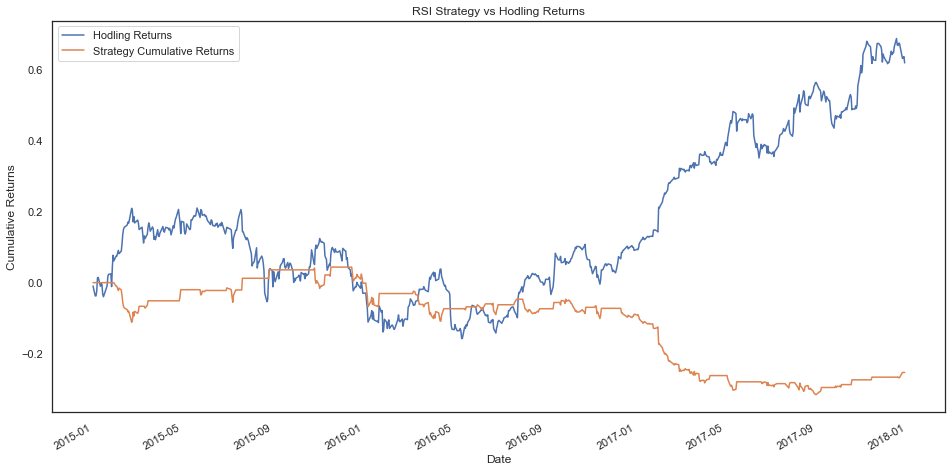

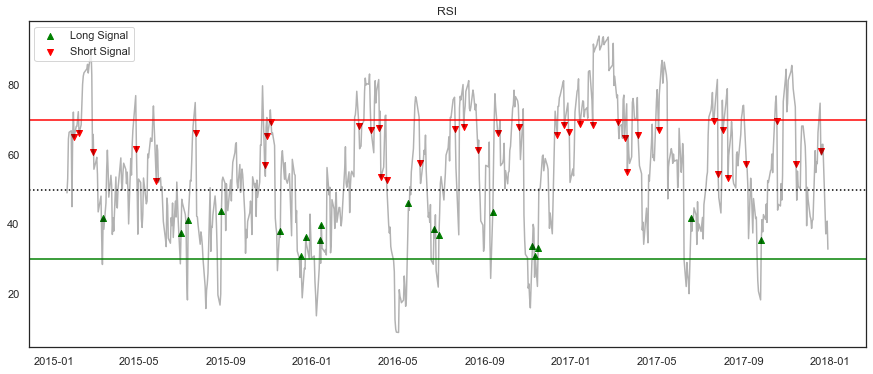

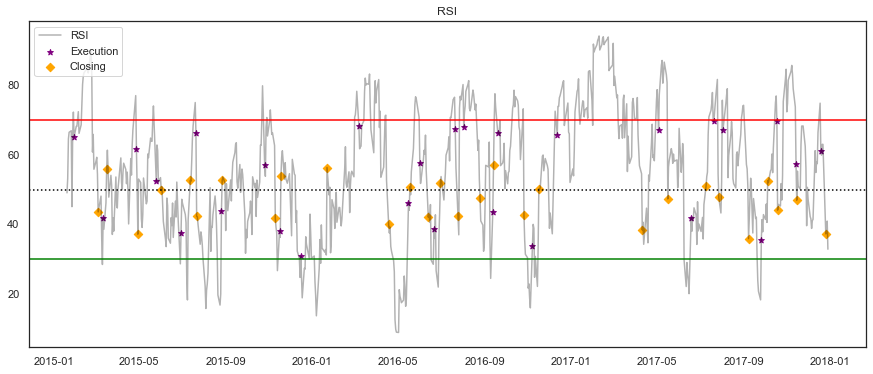

,Adj Close,Daily Change,Up,Down,RS,RSI,Yesterday RSI,Signal,Position,Execution,Closing,Capital,Cash,Stock_Holding,Daily_Stock_Value,Return,Strategy Cumulative Returns,Hodling Returns,Max Gross Performance,Drawdown
Date,,,,,,,,,,,,,,,,,,,,
2014-12-31,24.839495,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,100000.000000,100000.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.603210,-0.236284,NaN,NaN,NaN,NaN,NaN,0,0,0,0,100000.000000,100000.000000,0,0.000000,0.000000,0.000000,-0.009512,0.000000,0.000000
2015-01-05,23.910093,-0.693117,NaN,NaN,NaN,NaN,NaN,0,0,0,0,100000.000000,100000.000000,0,0.000000,0.000000,0.000000,-0.037416,0.000000,0.000000
2015-01-06,23.912344,0.002251,NaN,NaN,NaN,NaN,NaN,0,0,0,0,100000.000000,100000.000000,0,0.000000,0.000000,0.000000,-0.037326,0.000000,0.000000
2015-01-07,24.247650,0.335306,NaN,NaN,NaN,NaN,NaN,0,0,0,0,100000.000000,100000.000000,0,0.000000,0.000000,0.000000,-0.023827,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,41.604233,0.000000,0.148038,0.087001,1.701572,62.984511,62.984511,0,-1,0,0,73185.325333,132013.710495,-1414,-58828.385162,0.000000,-0.268147,0.674923,0.043831,0.311978
2017-12-26,40.548740,-1.055492,0.128300,0.216133,0.593615,37.249581,62.984511,0,0,0,1,74672.791588,74672.791588,0,0.000000,0.020121,-0.253272,0.632430,0.043831,0.297103
2017-12-27,40.555878,0.007137,0.112145,0.187315,0.598695,37.448993,37.249581,0,0,0,0,74672.791588,74672.791588,0,0.000000,0.000000,-0.253272,0.632717,0.043831,0.297103


In [70]:
RSIdf = RSIBacktester('AAPL')
RSIdf

In [71]:
RSIdf["Signal"].value_counts()

 0    700
-1     38
 1     18
Name: Signal, dtype: int64

In [72]:
RSIdf["Execution"].value_counts()

0    728
1     28
Name: Execution, dtype: int64

In [73]:
RSIdf["Closing"].value_counts()

0    728
1     28
Name: Closing, dtype: int64

![display image](https://i.gifer.com/fxgy.gif)

## Below is a scenario where we skip signal execution when we already have a position

In [74]:
RSIdf.loc['2015-01-29':'2015-02-28']

,Adj Close,Daily Change,Up,Down,RS,RSI,Yesterday RSI,Signal,Position,Execution,Closing,Capital,Cash,Stock_Holding,Daily_Stock_Value,Return,Strategy Cumulative Returns,Hodling Returns,Max Gross Performance,Drawdown
Date,,,,,,,,,,,,,,,,,,,,
2015-01-29,26.756805,0.807884,0.415098,0.159339,2.605132,72.261765,65.375412,0,0,0,0,100000.000000,100000.000000,0,0.000000,0.000000,0.000000,0.077188,0.0,0.000000
2015-01-30,26.365232,-0.391573,0.356867,0.191917,1.859489,65.028717,72.261765,-1,-1,1,0,99995.000000,179987.115307,-3034,-79992.115307,-0.000050,-0.000050,0.061424,0.0,0.000050
2015-02-02,26.696041,0.330809,0.353237,0.165180,2.138495,68.137593,65.028717,0,-1,0,0,98991.326588,179987.115307,-3034,-80995.788719,-0.010088,-0.010087,0.074742,0.0,0.010087
2015-02-03,26.700544,0.004503,0.304942,0.142305,2.142877,68.182022,68.137593,0,-1,0,0,98977.663727,179987.115307,-3034,-81009.451580,-0.000138,-0.010223,0.074923,0.0,0.010223
2015-02-04,26.905329,0.204784,0.291143,0.122699,2.372825,70.351263,68.182022,0,-1,0,0,98356.347878,179987.115307,-3034,-81630.767429,-0.006297,-0.016437,0.083167,0.0,0.016437
2015-02-05,27.097359,0.192030,0.277548,0.105869,2.621624,72.388079,70.351263,0,-1,0,0,97773.729000,179987.115307,-3034,-82213.386307,-0.005941,-0.022263,0.090898,0.0,0.022263
2015-02-06,26.869177,-0.228182,0.239623,0.122582,1.954800,66.156761,72.388079,-1,-1,0,0,98466.032700,179987.115307,-3034,-81521.082607,0.007056,-0.015340,0.081712,0.0,0.015340
2015-02-09,27.047657,0.178480,0.231296,0.105887,2.184361,68.596522,66.156761,0,-1,0,0,97924.523930,179987.115307,-3034,-82062.591377,-0.005515,-0.020755,0.088897,0.0,0.020755
2015-02-10,27.567284,0.519627,0.270452,0.091507,2.955525,74.718908,68.596522,0,-1,0,0,96347.976772,179987.115307,-3034,-83639.138535,-0.016231,-0.036520,0.109817,0.0,0.036520


### <font color = blue> 👉 Question 3</font>. How much in cumulative returns could you have had as a result of the RSI strategy?

### Below are the lines of code that lead to an answer:

# <font color = 'red'> Return Cumsum calculation </font>

In [75]:
RSIdf.tail(3)

,Adj Close,Daily Change,Up,Down,RS,RSI,Yesterday RSI,Signal,Position,Execution,Closing,Capital,Cash,Stock_Holding,Daily_Stock_Value,Return,Strategy Cumulative Returns,Hodling Returns,Max Gross Performance,Drawdown
Date,,,,,,,,,,,,,,,,,,,,
2017-12-27,40.555878,0.007137,0.112145,0.187315,0.598695,37.448993,37.249581,0,0,0,0,74672.791588,74672.791588,0,0.0,0.0,-0.253272,0.632717,0.043831,0.297103
2017-12-28,40.669991,0.114113,0.112407,0.162340,0.692419,40.912965,37.448993,0,0,0,0,74672.791588,74672.791588,0,0.0,0.0,-0.253272,0.637312,0.043831,0.297103
2017-12-29,40.230190,-0.439800,0.097420,0.199335,0.488724,32.828371,40.912965,0,0,0,0,74672.791588,74672.791588,0,0.0,0.0,-0.253272,0.619606,0.043831,0.297103


### <font color = red> Answer 3 </font>

    The answer is -25.329% .

### <font color = blue> 👉 Question 4</font>. Now please find the `five` worst drawdown periods over the investment horizon and provide their net drawdown in % and duration, respectively.

### <font color = green> The question asks you to find the five worst drawdown periods, beyond identifying max drawdown (MDD).

### Below are the lines of code that lead to an answer:

In [76]:
def Drawdowns(RSIdf):  
      
    index = RSIdf[RSIdf['Drawdown'] == 0].index  
  
    a = []  
  
    for i in range(1,len(index)):  
        period = index[i].to_pydatetime() - index[i-1].to_pydatetime()  
        max_drawdown = RSIdf.loc[index[i-1]:index[i],'Drawdown'].max()  
        a.append([period,max_drawdown,index[i-1],index[i]])  
      
    df1 = pd.DataFrame(a,columns=['Period','Max Drawdown','Beginning','End']).sort_values('Max Drawdown',ascending=False)  
  
    return df1.head(5)

In [77]:
Drawdowns(RSIdf)

,Period,Max Drawdown,Beginning,End
18,174 days,0.111783,2015-01-29,2015-07-22
85,22 days,0.057646,2015-10-27,2015-11-18
84,4 days,0.000050,2015-10-23,2015-10-27
43,2 days,0.000050,2015-08-25,2015-08-27
0,3 days,0.000000,2015-01-02,2015-01-05


Text(0.5, 1.0, 'Drawdowns')

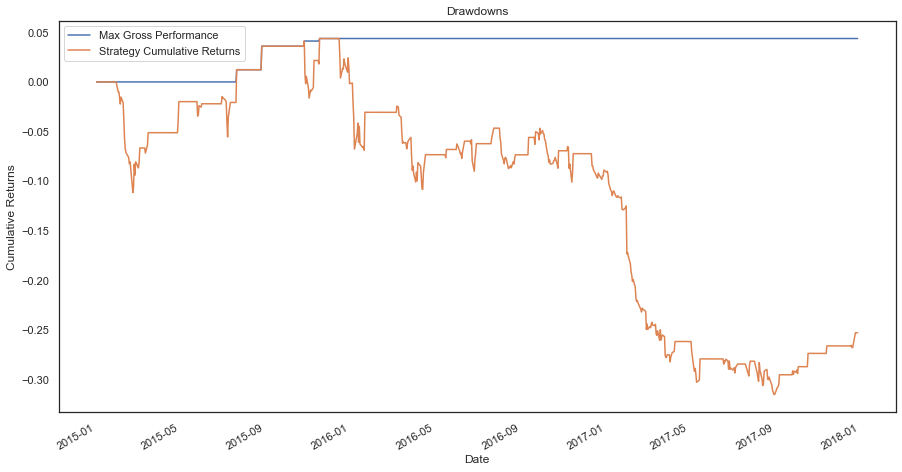

In [78]:
RSIdf[["Max Gross Performance", "Strategy Cumulative Returns"]].dropna().plot(figsize=(15,8)) 
plt.ylabel("Cumulative Returns") 
plt.title("Drawdowns")

## 0.005% Drawdowns?? It's the Trading Fee!

In [79]:
RSIdf.loc['2015-08-25':'2015-08-29']

,Adj Close,Daily Change,Up,Down,RS,RSI,Yesterday RSI,Signal,Position,Execution,Closing,Capital,Cash,Stock_Holding,Daily_Stock_Value,Return,Strategy Cumulative Returns,Hodling Returns,Max Gross Performance,Drawdown
Date,,,,,,,,,,,,,,,,,,,,
2015-08-25,23.641815,0.141291,0.098225,0.394310,0.249107,19.942807,16.758959,0,0,0,0,101233.402672,101233.402672,0,0.000000,0.000000,0.012334,-0.048217,0.012334,0.00000
2015-08-26,24.997789,1.355974,0.265925,0.341735,0.778161,43.762136,19.942807,1,1,1,0,101228.402672,20260.562860,3239,80967.839811,-0.000049,0.012284,0.006373,0.012334,0.00005
2015-08-27,25.733889,0.736099,0.328615,0.296171,1.109547,52.596451,43.762136,0,0,0,1,103607.628120,103607.628120,0,0.000000,0.023232,0.036076,0.036007,0.036076,0.00000
2015-08-28,25.818213,0.084324,0.296043,0.256681,1.153349,53.560706,52.596451,0,0,0,0,103607.628120,103607.628120,0,0.000000,0.000000,0.036076,0.039402,0.036076,0.00000


### <font color = red> Answer 4 </font>

    The Worst drawdown period     : Net drawdown 11.1784 % | Duration 173 Days
    
    The 2nd worst drawdown period : Net drawdown 5.765 % | Duration 22 Days
     
    The 3rd worst drawdown period : Net drawdown ____________ % | Duration ____________ Days
         
    The 4th worst drawdown period : Net drawdown ____________ % | Duration ____________ Days
    
    The 5th worst drawdown period : Net drawdown ____________ % | Duration ____________ Days

### <font color = blue> 👉 Question 5</font>. Within the investment horizon, please calculate annual returns for each of the three years and then find the year that performs better than average vs. less than average annual returns.

### Below are the lines of code that lead to an answer:

In [80]:
Avg_Annual_Returns = (np.exp(RSIdf["Return"].groupby(RSIdf.index.year).sum())-1).mean() 
Avg_Annual_Returns

-0.06736869326844808

In [81]:
Annualized_Returns = np.exp(RSIdf["Return"].groupby(RSIdf.index.year).sum())-1 
Annualized_Returns

Date
2014    0.000000
2015   -0.001805
2016   -0.087318
2017   -0.180352
Name: Return, dtype: float64

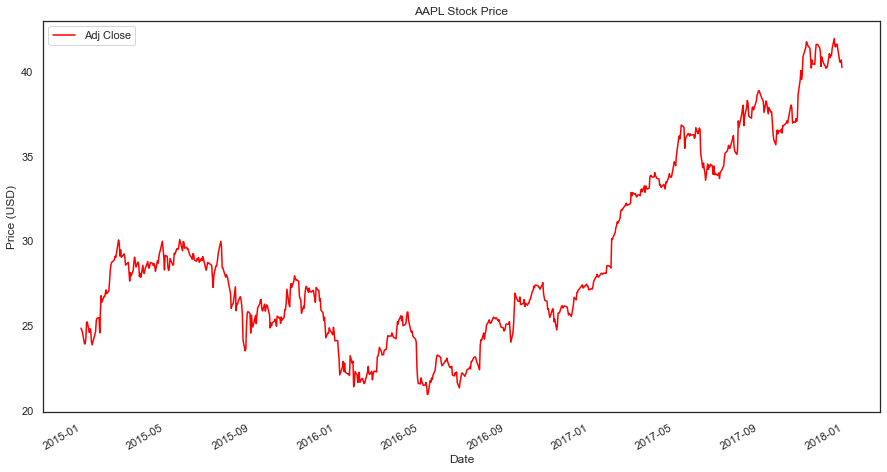

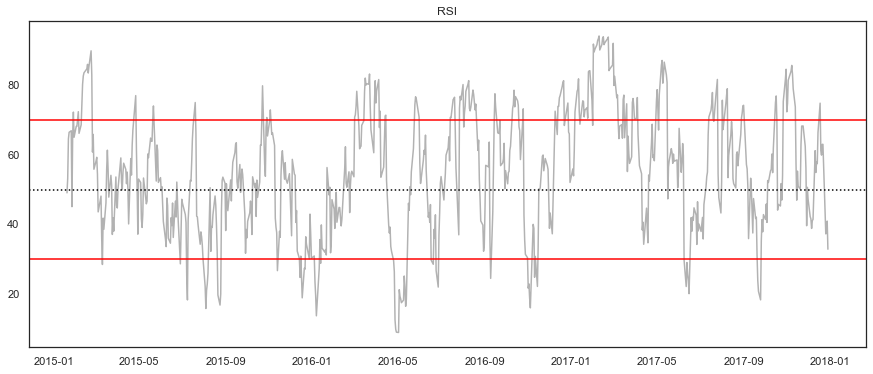

In [82]:
RSIdf[["Adj Close"]].dropna().plot(figsize=(15,8), color = 'red') 
plt.ylabel("Price (USD)") 
plt.title("AAPL Stock Price")

plt.figure(figsize=(15,6))
plt.plot(RSIdf.index, RSIdf['RSI'],color='black', alpha = 0.3)
plt.axhline(70 ,color = 'red')
plt.axhline(30 ,color='red')
plt.axhline(50 , linestyle = "dotted", color = 'black')
plt.title('RSI')
plt.show()

### <font color = red> Answer 5 </font>

    Below average year(s) : 2017 (-18.035%)
    
    Above average year(s) : 2015 (-0.182%) & 2016 (Barely at -8.732%)
     

###  <font color = blue> 👉 Question 6. </font> What's the annualized Sharpe ratio of the current investment strategy?

### Below are the lines of code that lead to an answer:

### Take the rows of DataFrame as n days to calculate annualized Sharpe Ratio 

In [83]:
RSIdf.shape[0]

756

In [84]:
def sharpe_ratio(RSIdf, periods_per_year = 252): 
     
    n_years = RSIdf.shape[0]/periods_per_year 
     
    annualized_return = np.power(np.prod(1 + RSIdf['Return']), (1 / n_years) 
                                 ) - 1 
     
    annualized_vol = RSIdf['Return'].std() * np.sqrt(periods_per_year) 
     
    annualized_sharpe = annualized_return / annualized_vol 
     
    return annualized_return, annualized_vol, annualized_sharpe

In [85]:
sharpe_ratio(RSIdf)

(-0.09867299521349793, 0.1141427752195669, -0.8644699151890162)

### <font color = red> Answer 6 </font>
    
    Sharpe ratio: -0.865
    

## 👇 <font color = "purple"> Bigger Question 7. ### 

### This bigger question is where you will execute a principal component analysis (PCA) based portfolio for asset allocation. 
<br>
    
### Go to [the list of SP 500 companies on Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).
    
    Step 1: Among the securities added to the S&P 500 component before January 2000, select the first 30 stocks. 
    
    Step 2: Your objective is to find the portfolio using PCA. Using what you learned in class, 
    identify the profile of each portfolio. 
    
    Step 3: Then backtest the performance of your portfolio, relative to the equal weight portfolio. 
    Here, as you learned in class, use 80% of your data for PCA and 20% for backtesting.
    
### <font color = "green"> NOTE: The investment horizon will be 20 years between 2000 and 2019    

### Below are the lines of code that lead to an answer:

## Importing the necessary libraries

In [86]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import warnings

## Activate Necessary Packages

In [87]:
# For unsupervised learning
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD # Singular value decomposition

from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA

# For EDA and Data Transformation
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix
import seaborn as sns

In [88]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

warnings.filterwarnings("ignore")

## Import Data

In [89]:
tickers = ["AAPL","MSFT","AMZN","BRK-B","UNH","JNJ","XOM","JPM","PG","NVDA",
           "CVX","HD","LLY","PFE","PEP","MRK","BAC","KO","COST","TMO","WMT",
           "MCD","ABT","DIS","DHR","CSCO","WFC","COP","VZ","BMY"]
# googled the first 30 stocks based on market cap and exist before January 2000

In [90]:
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
SPY_data = yf.download(tickers, interval="1d", start="2000-01-03", end="2020-01-01")

[*********************100%***********************]  30 of 30 completed


In [91]:
SPY_data

Adj Close                                                          \
                 AAPL        ABT       AMZN        BAC        BMY       BRK-B   
Date                                                                            
2000-01-03   0.851942   9.262774   4.468750  13.522099  26.770678   35.299999   
2000-01-04   0.780115   8.998129   4.096875  12.719502  24.745340   34.080002   
2000-01-05   0.791530   8.981584   3.487500  12.859087  24.586803   34.639999   
2000-01-06   0.723033   9.295856   3.278125  13.958302  24.925768   36.080002   
2000-01-07   0.757282   9.395101   3.478125  13.591896  28.575981   36.400002   
...               ...        ...        ...        ...        ...         ...   
2019-12-24  69.623238  83.220909  89.460503  33.078793  57.600086  225.470001   
2019-12-26  71.004585  83.220909  93.438499  33.360565  58.329662  226.449997   
2019-12-27  70.977631  83.335335  93.489998  33.200890  58.493816  226.139999   
2019-12-30  71.398895  82.763245  92.344498  33.013058  58.119907  225.759995   
2019-12-31  71.920570  82.820450  92.391998  33.078793  58.539413  226.500000   

                                                          ...      Volume  \
                  COP        COST       CSCO         CVX  ...        NVDA   
Date                                                      ...               
2000-01-03   8.393773   30.975521  38.369209   18.007626  ...  30091200.0   
2000-01-04   8.231679   29.278833  36.216618   18.007626  ...  30048000.0   
2000-01-05   8.081173   29.779140  36.105663   18.330631  ...  18835200.0   
2000-01-06   8.359036   30.377331  35.506496   19.111233  ...  12048000.0   
2000-01-07   8.359036   32.389420  37.592495   19.447704  ...   7118400.0   
...               ...         ...        ...         ...  ...         ...   
2019-12-24  57.619587  280.277100  43.510864  104.452370  ...  13886400.0   
2019-12-26  57.913620  281.705933  43.574608  104.678047  ...  18285200.0   
2019-12-27  57.895805  280.162750  43.501755  104.417656  ...  25464400.0   
2019-12-30  57.566139  281.143921  43.337837  104.027061  ...  25805600.0   
2019-12-31  57.940357  279.981750  43.674782  104.599937  ...  23100400.0   

                                                                     \
                   PEP         PFE         PG       TMO         UNH   
Date                                                                  
2000-01-03   5298400.0  12873345.0  4275000.0  432200.0   3431200.0   
2000-01-04   4555700.0  14208974.0  4270800.0  568400.0   5997600.0   
2000-01-05   5701900.0  12981591.0  5098400.0  490800.0  10562400.0   
2000-01-06   6863100.0  11115273.0  6524200.0  561900.0  15300000.0   
2000-01-07  10527800.0  17962163.0  9832000.0  266600.0  16160800.0   
...                ...         ...        ...       ...         ...   
2019-12-24   1220600.0   5187683.0  2022100.0  489200.0    714000.0   
2019-12-26   2934700.0   9384078.0  4760400.0  680700.0   1050600.0   
2019-12-27   2554000.0  10117662.0  5192000.0  628800.0   1547100.0   
2019-12-30   3024700.0  11554264.0  3884300.0  606600.0   1511700.0   
2019-12-31   3229400.0  15175703.0  4798900.0  875800.0   2224200.0   

                                                          
                   VZ         WFC        WMT         XOM  
Date                                                      
2000-01-03  4663843.0   9037000.0  8369900.0  13458200.0  
2000-01-04  5005878.0  15237200.0  6745100.0  14510800.0  
2000-01-05  6368681.0   8228200.0  7018700.0  17485000.0  
2000-01-06  4705763.0   8326800.0  6544500.0  19461600.0  
2000-01-07  5043907.0   7711200.0  7976900.0  16603800.0  
...               ...         ...        ...         ...  
2019-12-24  6640100.0   4635500.0  2227400.0   3979400.0  
2019-12-26  8117800.0  12517100.0  4223800.0   8840200.0  
2019-12-27  8166800.0   9892000.0  3544000.0  10516100.0  
2019-12-30  6765400.0  10900500.0  2945800.0  12689400.0  
2019-12-31  8466700.0  12566000.0  4

In [92]:
SPY_table = SPY_data["Adj Close"] 
SPY_table

,AAPL,ABT,AMZN,BAC,BMY,BRK-B,COP,COST,CSCO,CVX,...,NVDA,PEP,PFE,PG,TMO,UNH,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.851942,9.262774,4.468750,13.522099,26.770678,35.299999,8.393773,30.975521,38.369209,18.007626,...,0.895276,21.088810,13.859154,29.150448,12.336596,5.520475,19.062679,10.435799,44.386997,19.130632
2000-01-04,0.780115,8.998129,4.096875,12.719502,24.745340,34.080002,8.231679,29.278833,36.216618,18.007626,...,0.871371,20.552647,13.342828,28.589542,11.873975,5.449865,18.446474,9.919006,42.726105,18.764200
2000-01-05,0.791530,8.981584,3.487500,12.859087,24.586803,34.639999,8.081173,29.779140,36.105663,18.330631,...,0.842683,20.052233,13.560225,28.045612,11.976781,5.437027,19.062679,9.818987,41.854145,19.787153
2000-01-06,0.723033,9.295856,3.278125,13.958302,24.925768,36.080002,8.359036,30.377331,35.506496,19.111233,...,0.787700,20.945833,14.049371,29.337421,11.976781,5.636019,18.965862,10.252416,42.310879,20.810093
2000-01-07,0.757282,9.395101,3.478125,13.591896,28.575981,36.400002,8.359036,32.389420,37.592495,19.447704,...,0.800848,21.517733,15.000494,31.683073,12.130988,6.297195,18.825809,10.435799,45.508087,20.749025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,69.623238,83.220909,89.460503,33.078793,57.600086,225.470001,57.619587,280.277100,43.510864,104.452370,...,59.464371,126.655334,33.381397,116.316010,324.527039,283.009766,53.251373,49.873192,114.346428,58.754559
2019-12-26,71.004585,83.220909,93.438499,33.360565,58.329662,226.449997,57.913620,281.705933,43.574608,104.678047,...,59.606419,126.470291,33.457859,116.316010,323.731873,284.076385,53.260063,50.178997,114.356010,58.846867
2019-12-27,70.977631,83.335335,93.489998,33.200890,58.493816,226.139999,57.895805,280.162750,43.501755,104.417656,...,59.028271,127.256752,33.406887,117.124146,324.566772,284.383850,53.468620,49.965862,114.422966,58.645485


In [93]:
SPY_table.columns

Index(['AAPL', 'ABT', 'AMZN', 'BAC', 'BMY', 'BRK-B', 'COP', 'COST', 'CSCO',
       'CVX', 'DHR', 'DIS', 'HD', 'JNJ', 'JPM', 'KO', 'LLY', 'MCD', 'MRK',
       'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'TMO', 'UNH', 'VZ', 'WFC', 'WMT',
       'XOM'],
      dtype='object')

## Data Transformation

In [94]:
missing_frac = SPY_table.isnull().mean().sort_values(ascending = False)

missing_frac.head() #to check the number of missing values per column

AAPL    0.000199
ABT     0.000199
WMT     0.000199
WFC     0.000199
VZ      0.000199
dtype: float64

In [95]:
SPY_table = SPY_table.fillna(method = "ffill")

In [96]:
SPY_table= SPY_table.dropna(axis = 0)
SPY_table

,AAPL,ABT,AMZN,BAC,BMY,BRK-B,COP,COST,CSCO,CVX,...,NVDA,PEP,PFE,PG,TMO,UNH,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.851942,9.262774,4.468750,13.522099,26.770678,35.299999,8.393773,30.975521,38.369209,18.007626,...,0.895276,21.088810,13.859154,29.150448,12.336596,5.520475,19.062679,10.435799,44.386997,19.130632
2000-01-04,0.780115,8.998129,4.096875,12.719502,24.745340,34.080002,8.231679,29.278833,36.216618,18.007626,...,0.871371,20.552647,13.342828,28.589542,11.873975,5.449865,18.446474,9.919006,42.726105,18.764200
2000-01-05,0.791530,8.981584,3.487500,12.859087,24.586803,34.639999,8.081173,29.779140,36.105663,18.330631,...,0.842683,20.052233,13.560225,28.045612,11.976781,5.437027,19.062679,9.818987,41.854145,19.787153
2000-01-06,0.723033,9.295856,3.278125,13.958302,24.925768,36.080002,8.359036,30.377331,35.506496,19.111233,...,0.787700,20.945833,14.049371,29.337421,11.976781,5.636019,18.965862,10.252416,42.310879,20.810093
2000-01-07,0.757282,9.395101,3.478125,13.591896,28.575981,36.400002,8.359036,32.389420,37.592495,19.447704,...,0.800848,21.517733,15.000494,31.683073,12.130988,6.297195,18.825809,10.435799,45.508087,20.749025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,69.623238,83.220909,89.460503,33.078793,57.600086,225.470001,57.619587,280.277100,43.510864,104.452370,...,59.464371,126.655334,33.381397,116.316010,324.527039,283.009766,53.251373,49.873192,114.346428,58.754559
2019-12-26,71.004585,83.220909,93.438499,33.360565,58.329662,226.449997,57.913620,281.705933,43.574608,104.678047,...,59.606419,126.470291,33.457859,116.316010,323.731873,284.076385,53.260063,50.178997,114.356010,58.846867
2019-12-27,70.977631,83.335335,93.489998,33.200890,58.493816,226.139999,57.895805,280.162750,43.501755,104.417656,...,59.028271,127.256752,33.406887,117.124146,324.566772,284.383850,53.468620,49.965862,114.422966,58.645485


## Correlation Matrix of first 30 securities by market cap in S&P 500

<AxesSubplot:title={'center':'Correlation Matrix of first 30 securities in S&P 500'}>

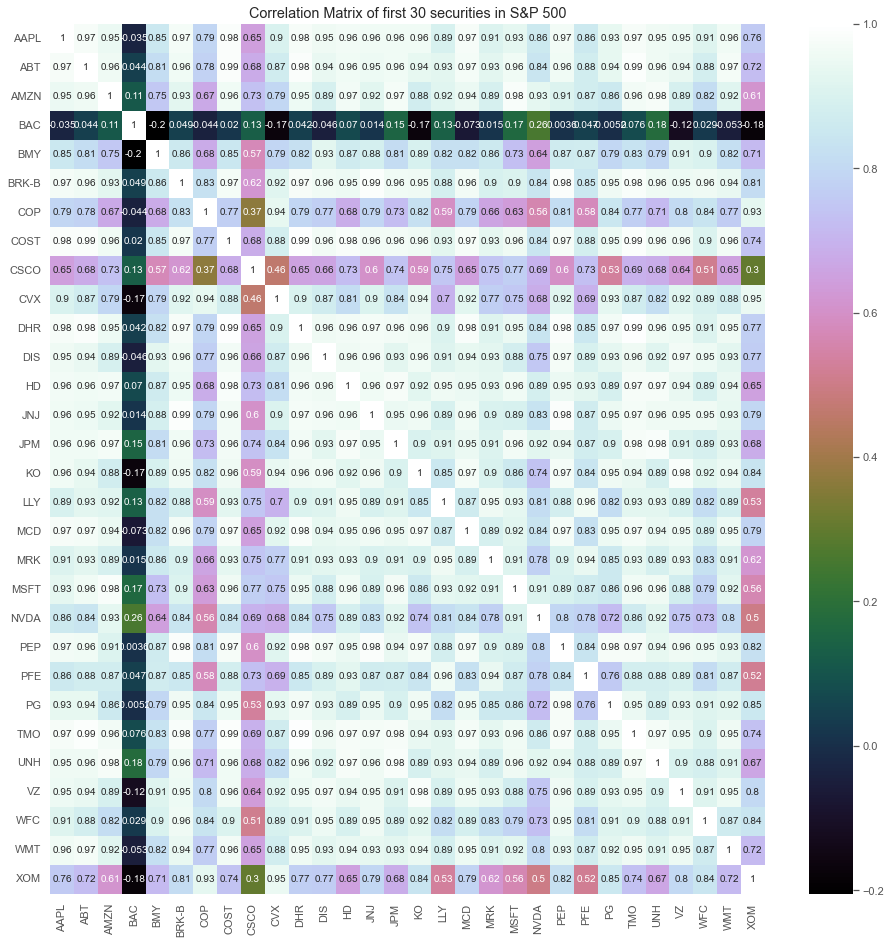

In [97]:
corr = SPY_table.corr()

plt.figure(figsize = (16,16)
          )

plt.title("Correlation Matrix of first 30 securities in S&P 500")

sns.heatmap(corr,
            annot = True,
            cmap = "cubehelix")

## Calculation of Daily Linear Return

In [98]:
daily_linear_returns = SPY_table.pct_change(1)

In [99]:
daily_linear_returns = \
    daily_linear_returns[ \
         daily_linear_returns.apply(lambda x:(x - x.mean()
                                             ).abs() < (3 * x.std()
                                                       )
                                   ).all(1)
                        ]

In [100]:
daily_linear_returns

,AAPL,ABT,AMZN,BAC,BMY,BRK-B,COP,COST,CSCO,CVX,...,NVDA,PEP,PFE,PG,TMO,UNH,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-0.051151,-0.014185,-0.035230,-0.021276,-0.013837,-0.018753,-0.001389,-0.035526,-0.030165,-0.009246,...,-0.040463,-0.003390,-0.012703,0.015633,0.008547,0.002075,-0.009348,-0.016501,-0.014869,0.002985
2000-01-14,0.038113,0.022221,-0.025592,0.061761,0.027725,-0.033523,-0.008498,0.033575,0.012949,-0.006423,...,0.043028,0.006957,0.000000,0.017391,-0.016807,-0.001013,0.013498,0.030912,-0.009597,-0.019752
2000-01-20,0.065102,-0.030246,-0.030870,-0.019206,-0.034146,-0.005266,-0.028369,-0.036145,0.000557,-0.004975,...,-0.002756,-0.008577,-0.016469,-0.024377,0.017544,0.025210,0.003253,-0.010204,-0.010732,-0.021913
2000-02-02,-0.014339,0.005704,0.029657,-0.025511,0.002901,-0.020896,-0.013824,0.039759,-0.033422,-0.006762,...,0.028006,-0.029412,-0.027026,-0.008794,-0.017668,0.026406,-0.004197,-0.030273,-0.005325,0.007512
2000-02-04,0.045372,0.035715,-0.066815,-0.012114,-0.010517,-0.008982,-0.009524,-0.021915,0.028117,-0.035303,...,0.023659,-0.009452,0.003509,-0.031310,-0.007118,0.024831,0.002139,-0.008038,-0.035332,-0.018210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.000951,-0.000802,-0.002114,0.001422,-0.000791,-0.000044,0.001083,0.003137,-0.006653,0.000083,...,-0.000837,-0.001095,-0.000763,0.002562,-0.004664,-0.001864,-0.001954,0.000186,0.004033,-0.003841
2019-12-26,0.019840,0.000000,0.044467,0.008518,0.012666,0.004346,0.005103,0.005098,0.001465,0.002161,...,0.002389,-0.001461,0.002291,0.000000,-0.002450,0.003769,0.000163,0.006132,0.000084,0.001571
2019-12-27,-0.000380,0.001375,0.000551,-0.004786,0.002814,-0.001369,-0.000308,-0.005478,-0.001672,-0.002488,...,-0.009699,0.006219,-0.001523,0.006948,0.002579,0.001082,0.003916,-0.004247,0.000586,-0.003422


## Scaling S&P 500 data
* Scaling is a technique to make the data points generalized so that the distance between them is lower 
* it transforms attributes to a standard Normal distribution with a mean of 0 and a standard deviation of 1
* By scaling the data it makes it easy for the model to learn and understand the problem
* A standardized dataset improves the prediction accuracy of the algorithm compared to an unstandardized one

In [101]:
scaler = StandardScaler().fit(daily_linear_returns)

In [102]:
scaled_SPY = pd.DataFrame(scaler.fit_transform(daily_linear_returns),
                          columns = daily_linear_returns.columns,
                          index = daily_linear_returns.index)

In [103]:
daily_linear_returns.dropna(how = "any",
                            inplace = True)

scaled_SPY.dropna(how = "any",
                  inplace = True)

scaled_SPY

,AAPL,ABT,AMZN,BAC,BMY,BRK-B,COP,COST,CSCO,CVX,...,NVDA,PEP,PFE,PG,TMO,UNH,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-2.764484,-1.301981,-1.699568,-1.229702,-1.136108,-1.897041,-0.140970,-2.890431,-1.892495,-0.798813,...,-1.570119,-0.437173,-1.118262,1.689782,0.565577,0.081523,-0.848498,-1.150388,-1.416355,0.219217
2000-01-14,1.931310,1.897262,-1.245466,3.518395,2.118408,-3.360202,-0.605445,2.608837,0.761679,-0.572855,...,1.549836,0.734681,-0.023045,1.886224,-1.313230,-0.131990,1.142931,2.115462,-0.920031,-1.726390
2000-01-20,3.351081,-2.713401,-1.494127,-1.111322,-2.726392,-0.560912,-1.903669,-2.939631,-0.001207,-0.456939,...,-0.161038,-1.024620,-1.442918,-2.781154,1.232296,1.681270,0.249955,-0.716608,-1.026850,-1.911393
2000-02-02,-0.827991,0.445722,1.357679,-1.471827,0.174621,-2.109263,-0.953415,3.100956,-2.092981,-0.599937,...,0.988495,-3.384463,-2.353135,-1.039818,-1.377045,1.764005,-0.399500,-2.099009,-0.517863,0.606640
2000-02-04,2.313158,3.083032,-3.187727,-0.705808,-0.876059,-0.929034,-0.672432,-1.807217,1.695463,-2.884422,...,0.826056,-1.123800,0.279457,-3.555815,-0.595254,1.655053,0.152839,-0.567437,-3.342628,-1.594468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.023654,-0.125917,-0.139242,0.068170,-0.114507,-0.043591,0.020560,0.186474,-0.445032,-0.052085,...,-0.089350,-0.177206,-0.088829,0.229144,-0.413400,-0.190805,-0.203989,-0.000962,0.363035,-0.364925
2019-12-26,0.970042,-0.055482,2.055444,0.473965,0.939267,0.391391,0.283180,0.342542,0.054714,0.114213,...,0.031213,-0.218713,0.174436,-0.057131,-0.249349,0.198674,-0.019406,0.408598,-0.008687,0.098226
2019-12-27,-0.093639,0.065345,-0.013682,-0.286799,0.167806,-0.174818,-0.070318,-0.499112,-0.138402,-0.257826,...,-0.420510,0.651076,-0.154392,0.719242,0.123338,0.012909,0.307698,-0.306328,0.038541,-0.329053


In [104]:
scaled_SPY.dtypes

AAPL     float64
ABT      float64
AMZN     float64
BAC      float64
BMY      float64
BRK-B    float64
COP      float64
COST     float64
CSCO     float64
CVX      float64
DHR      float64
DIS      float64
HD       float64
JNJ      float64
JPM      float64
KO       float64
LLY      float64
MCD      float64
MRK      float64
MSFT     float64
NVDA     float64
PEP      float64
PFE      float64
PG       float64
TMO      float64
UNH      float64
VZ       float64
WFC      float64
WMT      float64
XOM      float64
dtype: object

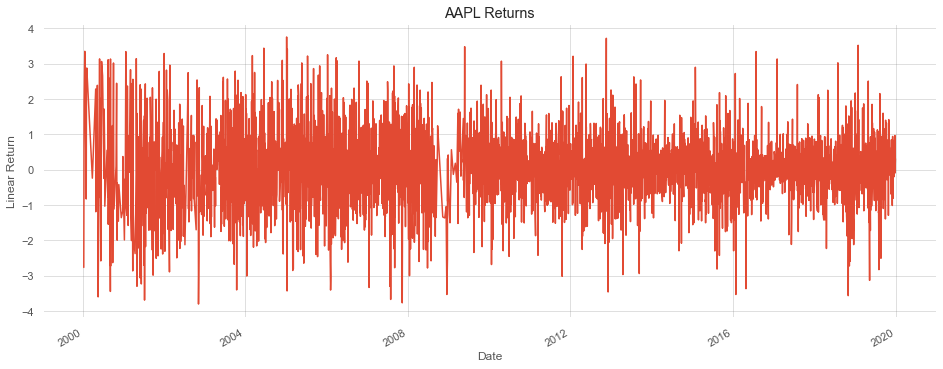

In [105]:
plt.figure(figsize = (16, 6)
           )

plt.title("AAPL Returns")

plt.ylabel("Linear Return")

scaled_SPY.AAPL.plot()

plt.show()

## Data Splitting
* Splitting the dataset into training set 80% and testing set 20%

In [106]:
prop = int(len(scaled_SPY) * 0.80)

X_Train = scaled_SPY[:prop]

X_Test = scaled_SPY[prop:]

X_Train_Raw = daily_linear_returns[:prop]

X_Test_Raw = daily_linear_returns[prop:]

In [107]:
stock_tickers = scaled_SPY.columns.values

In [108]:
n_tickers = len(stock_tickers)

## Applying Principle Component Analysis

In [109]:
pca = PCA()

PrincipalComponent = pca.fit(X_Train)

## First Principal Component/ Eigenvector

In [110]:
pca.components_[0]

array([-0.15 , -0.172, -0.152, -0.202, -0.171, -0.166, -0.162, -0.174,
       -0.192, -0.194, -0.214, -0.205, -0.196, -0.183, -0.232, -0.175,
       -0.184, -0.149, -0.188, -0.194, -0.144, -0.169, -0.202, -0.175,
       -0.194, -0.146, -0.168, -0.216, -0.168, -0.202])

## Explained Variance
* Explained variance is a statistical measure of how much variation in a dataset can be attributed to each of the `principal components (eigenvectors)` generated by the principal component analysis (PCA) method.
* it refers to the amount of variability in a data set that can be attributed to each individual principal component, how much of the total variance is explained by each component
* The higher the explained variance would be better as it tells us that the model is doing a better job in predicting the optimal portfolio

In [111]:
NumEigenvalues = 10

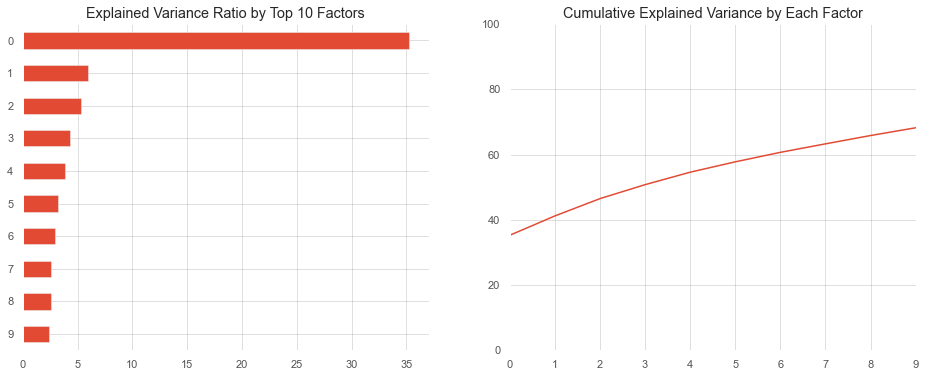

In [112]:
fig, axes = plt.subplots(ncols = 2,
                         figsize = (16, 6)
                         )

Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]
                   ).sort_values() * 100

Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]
                   ).cumsum()*100

Series1.plot.barh(ylim = (0, 9),
                  title = "Explained Variance Ratio by Top 10 Factors",
                  ax = axes[0]
                  );

Series2.plot(ylim = (0, 100),
             xlim = (0, 9),
             ax = axes[1],
             title = "Cumulative Explained Variance by Each Factor");

In [113]:
pd.Series(np.cumsum(pca.explained_variance_ratio_)
          ).to_frame("Explained Variance").head(NumEigenvalues).style.format("{:,.2%}".format)
# the first PC will explain 35.28% and together with the second PC it will explain 41.20 % of the data. 
# its a cumulative sum of the entire explained variance

,Explained Variance
0,35.28%
1,41.20%
2,46.50%
3,50.78%
4,54.61%
5,57.78%
6,60.69%
7,63.29%
8,65.85%
9,68.22%


## Portfolio Weights

In [114]:
def PCWeights():
    """
    Principal Components Weights
    """
    weights = pd.DataFrame()
    
    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i]
                                                                   )
        
    weights = weights.values.T
    return weights

weights = PCWeights()

In [115]:
weights.shape

(30, 30)

In [116]:
weights[0]

array([0.028, 0.032, 0.028, 0.037, 0.031, 0.03 , 0.03 , 0.032, 0.035,
       0.036, 0.039, 0.038, 0.036, 0.034, 0.043, 0.032, 0.034, 0.027,
       0.035, 0.036, 0.026, 0.031, 0.037, 0.032, 0.036, 0.027, 0.031,
       0.04 , 0.031, 0.037])

In [117]:
weights[4]

array([-26.042, -44.445, -18.144,   5.61 , -74.334,   6.607,   8.045,
        52.339, -24.295,  12.549,   1.993,   2.343,  39.539, -17.952,
         2.664,  69.304, -54.92 ,  45.2  , -62.276,  -6.309, -47.815,
        70.516, -62.257,  60.978, -35.758, -38.602,  38.231,  13.33 ,
        63.755,  21.144])

array([[<AxesSubplot:title={'center':'Portfolio 0'}>],
       [<AxesSubplot:title={'center':'Portfolio 1'}>],
       [<AxesSubplot:title={'center':'Portfolio 2'}>],
       [<AxesSubplot:title={'center':'Portfolio 3'}>],
       [<AxesSubplot:title={'center':'Portfolio 4'}>]], dtype=object)

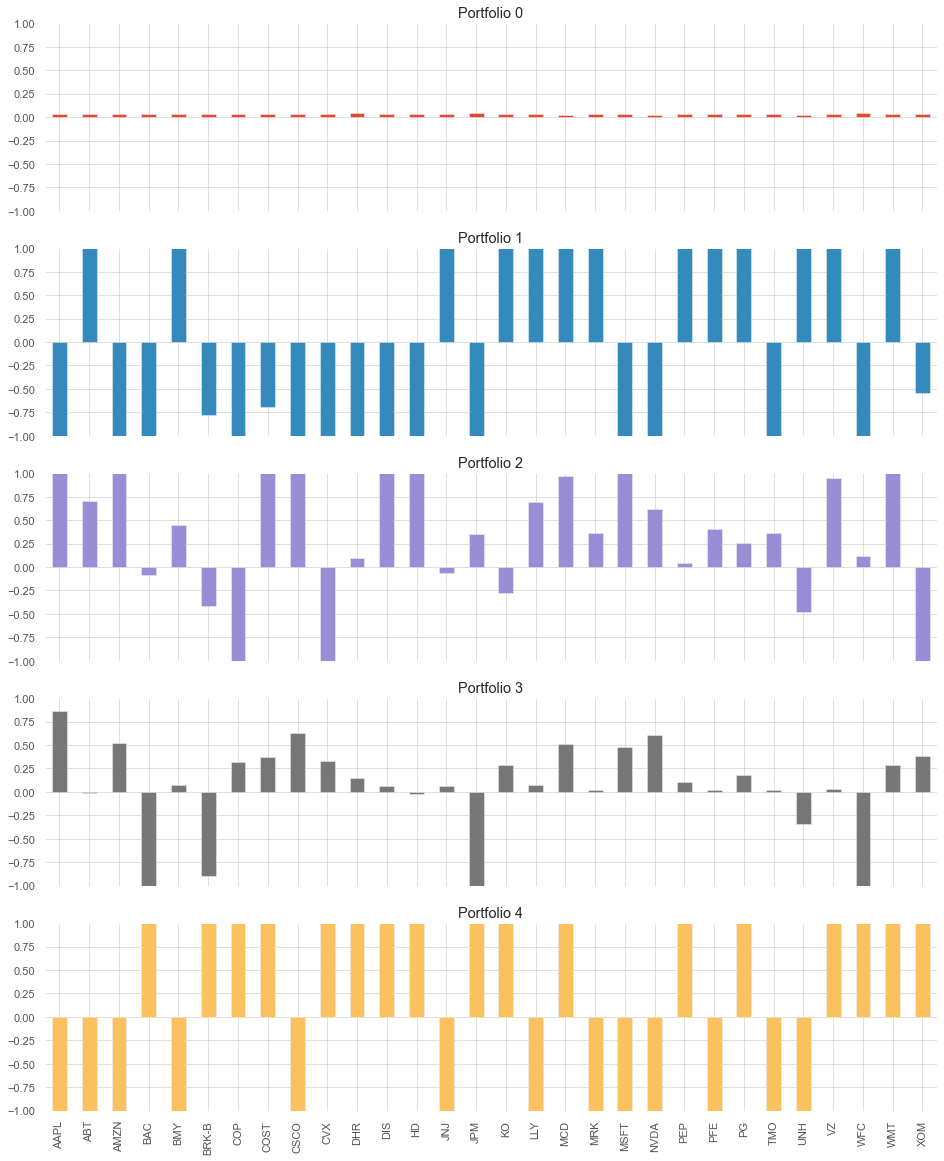

In [118]:
NumComponents = 5

topPortfolios = pd.DataFrame(pca.components_[:NumComponents],
                             columns = SPY_table.columns)

eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis = 0)

eigen_portfolios.index = [f"Portfolio {i}" for i in range( NumComponents)
                          ]

np.sqrt(pca.explained_variance_)

eigen_portfolios.T.plot.bar(subplots = True,
                            layout = (int(NumComponents), 1),
                            legend = False,
                            sharey = True,
                            ylim = (-1, 1),
                            figsize = (16, 20)
                           )
# gives us the allocation of weights of each stock for each eigenportfolio generated by the principal component

## Finding the best Eigen Portfolio

In [119]:
def sharpe_ratio(ts_returns, periods_per_year = 252):
    
    n_years = ts_returns.shape[0]/periods_per_year
    
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)
                                 ) - 1
    
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    
    annualized_sharpe = annualized_return / annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe
#We use the Sharpe ratio to determine the optimal eigen portfolio.
#Because the Sharpe ratio is an assessment of risk-adjusted performance, 
#it explains the annualized returns against the annualized volatility of a portfolio.

In [120]:
def FindOptimalPortfolio():
    
    n_portfolios = len(pca.components_)
    
    annualized_ret = np.array([0.] * n_portfolios)
    
    sharpe_metric = np.array([0.] * n_portfolios)
    
    annualized_vol = np.array([0.] * n_portfolios)
    
    highest_sharpe = 0
    
    stock_tickers = scaled_SPY.columns.values
    
    n_tickers = len(stock_tickers)
    
    PCs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = PCs[i] / sum(PCs[i]
                           )
        
        eigen_prtfi = pd.DataFrame(data = {"weights": pc_w.squeeze()*100}, 
                                   index = stock_tickers)
        
        eigen_prtfi.sort_values(by = ["weights"],
                                ascending = False,
                                inplace = True)
        
        eigen_prti_returns = np.dot(X_Train_Raw.loc[:, eigen_prtfi.index], 
                                    pc_w)
        
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(),
                                       index = X_Train_Raw.index)
        
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        
        annualized_ret[i] = er
        
        annualized_vol[i] = vol
        
        sharpe_metric[i] = sharpe
        
        sharpe_metric = np.nan_to_num(sharpe_metric)
        
    # HOW TO FIND A PORTFOLIO with the HIGHEST Sharpe Ratio
    
    
    
    highest_sharpe = np.argmax(sharpe_metric)
    
    print("Our Eigen Portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f" %
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100,
           annualized_vol[highest_sharpe]*100,
           sharpe_metric[highest_sharpe]
          )
         )
        
    results = pd.DataFrame(data = {"Return": annualized_ret, "Vol": annualized_vol, "Sharpe": sharpe_metric}
                           )
    
    results.dropna(inplace = True)
    
    results.sort_values(by = ["Sharpe"],
                        ascending = False,
                        inplace = True)
    
    print(results.head(15)
         )

In [121]:
FindOptimalPortfolio()
# We construct a loop to calculate the weights of the principle components of each eigen portfolio 
# and then use the Sharpe ratio function to find the portfolio with the highest Sharpe ratio.

Our Eigen Portfolio #4 with the highest Sharpe. Return inf%, vol = 4128.52%, Sharpe = 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00
      Return        Vol         Sharpe
4        inf  41.285193  1.797693e+308
0   0.125810   0.128538   9.787717e-01
3   0.167484   0.675534   2.479278e-01
11 -0.058345   1.413356  -4.128096e-02
13 -1.000000  17.529630  -5.704627e-02
29 -1.000000   6.869202  -1.455773e-01
27 -0.167541   1.138032  -1.472201e-01
22 -1.000000   6.487018  -1.541540e-01
26 -0.447844   2.094697  -2.137991e-01
23 -0.999995   4.144510  -2.412820e-01
9  -0.999226   3.826429  -2.611379e-01
15 -0.999391   3.812168  -2.621582e-01
24 -0.999038   3.755964  -2.659870e-01
8  -0.997240   3.391304  -2.940579e-01
17 -0.999092   3

In [122]:
# 1.Unrealistic weights
# 2.This assumes unlimited short selling and leverage
# 3.Frictionless market (A frictionless market is a theoretical trading environment
# where all costs and restraints associated with transactions are non-existent. 
# Which means no trading fees, no execution risk, and unrealistic Supply and Demand 
# (which means if there is high demand for a certain stock, then the stock price will be high). 
##( check with stephen on supply and demand explaination)


![Wolf of Wall Street Clip - Money Throwing Off Yacht](https://i.makeagif.com/media/7-11-2015/lbFRj6.gif)

In [123]:
weights = PCWeights()

portfolio = pd.DataFrame()

def VisualizeEigen(weights,
                   plot = False,
                   portfolio = portfolio):
    
    portfolio = pd.DataFrame(data = {"weights": weights.squeeze()*100},
                             index = stock_tickers)
    
    portfolio.sort_values(by = ["weights"],
                          ascending = False,
                          inplace = True)
    
    if plot:
        
        print("Total weights of our Eigen-Portfolio: %2.f" % np.sum(portfolio)
             )
        
        portfolio.plot(figsize = (14, 10),
                       title = "Eigen-Portfolio Weights",
                       rot = 60,
                       xticks = range(0, len(stock_tickers), 1)
                      )
        
        plt.show()
        
    return portfolio

In [124]:
weights[4].sum()

0.9999999999999858

Total weights of our Eigen-Portfolio: 100


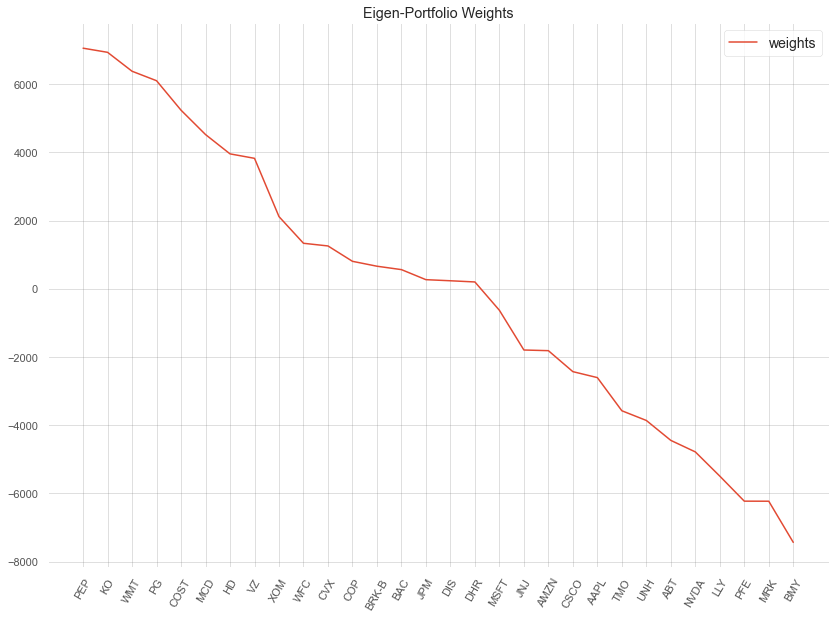

,weights
PEP,7051.643733
KO,6930.378354
WMT,6375.510879
PG,6097.849444
COST,5233.927272
MCD,4519.972431
HD,3953.866962
VZ,3823.117762
XOM,2114.406841
WFC,1332.999621


In [125]:
VisualizeEigen(weights = weights[4],
               plot = True)
# For those components in our portfolio that are positive (long/buy)
# For those components in our portfolio that are negative (short/sell)

### How we get this infinite return

In [126]:
X_Test_Raw

,AAPL,ABT,AMZN,BAC,BMY,BRK-B,COP,COST,CSCO,CVX,...,NVDA,PEP,PFE,PG,TMO,UNH,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-17,-0.022758,-0.002934,-0.015498,0.006762,-0.014778,-0.008874,0.022938,-0.003388,0.002771,0.004947,...,-0.017455,-0.004237,-0.015252,-0.003357,-0.006724,-0.006995,0.005986,-0.005336,-0.004909,-0.005482
2016-06-20,-0.002413,0.009628,0.010787,0.010448,0.004104,0.006679,0.012231,0.003784,-0.005181,0.010239,...,0.017980,-0.000387,0.008183,-0.001082,0.014565,0.006028,-0.000372,0.007082,0.002114,0.004409
2016-06-21,0.008517,-0.000530,0.002535,0.005908,0.004087,0.013129,0.002461,0.004601,-0.001042,0.006140,...,-0.006098,0.006869,0.007246,0.004456,0.003640,-0.002382,0.006324,0.006392,0.005063,0.004500
2016-06-22,-0.003754,0.026769,-0.007292,-0.000734,0.014877,0.002857,-0.018080,0.005853,-0.001738,-0.009202,...,-0.000846,-0.003267,-0.008058,0.001918,0.006312,-0.002099,-0.001294,-0.005505,0.004058,-0.003933
2016-06-23,0.005756,0.022974,0.016155,0.031595,0.004564,0.014173,0.037281,-0.006894,0.017410,0.021019,...,0.026678,0.006748,0.003481,0.007658,0.015282,0.009355,0.011845,0.020013,0.004878,0.006910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.000951,-0.000802,-0.002114,0.001422,-0.000791,-0.000044,0.001083,0.003137,-0.006653,0.000083,...,-0.000837,-0.001095,-0.000763,0.002562,-0.004664,-0.001864,-0.001954,0.000186,0.004033,-0.003841
2019-12-26,0.019840,0.000000,0.044467,0.008518,0.012666,0.004346,0.005103,0.005098,0.001465,0.002161,...,0.002389,-0.001461,0.002291,0.000000,-0.002450,0.003769,0.000163,0.006132,0.000084,0.001571
2019-12-27,-0.000380,0.001375,0.000551,-0.004786,0.002814,-0.001369,-0.000308,-0.005478,-0.001672,-0.002488,...,-0.009699,0.006219,-0.001523,0.006948,0.002579,0.001082,0.003916,-0.004247,0.000586,-0.003422


In [127]:
(X_Test_Raw * weights[4]).sum(1) # daily returns of portfolio 4

Date
2016-06-17    4.900805
2016-06-20   -1.218883
2016-06-21    1.554457
2016-06-22   -4.107603
2016-06-23   -2.775845
                ...   
2019-12-24    1.382079
2019-12-26   -1.624644
2019-12-27    1.010419
2019-12-30    0.949543
2019-12-31   -1.544003
Length: 804, dtype: float64

In [128]:
((X_Test_Raw * weights[4]).sum(1) + 1) # we add 1 to facilitate cumulative sum 
# if you notice, some of the daily returns are still negative despite us adding 1
# so if we take the cumsum of the daily returns, the cumsum() will just "ignore" big negative numbers

Date
2016-06-17    5.900805
2016-06-20   -0.218883
2016-06-21    2.554457
2016-06-22   -3.107603
2016-06-23   -1.775845
                ...   
2019-12-24    2.382079
2019-12-26   -0.624644
2019-12-27    2.010419
2019-12-30    1.949543
2019-12-31   -0.544003
Length: 804, dtype: float64

In [129]:
np.log((X_Test_Raw * weights[4]).sum(1) + 1).cumsum() # this is why when we take np.log of a negative number
# we get NaN value

Date
2016-06-17      1.775089
2016-06-20           NaN
2016-06-21      2.712928
2016-06-22           NaN
2016-06-23           NaN
                 ...    
2019-12-24    278.782462
2019-12-26           NaN
2019-12-27    279.480805
2019-12-30    280.148400
2019-12-31           NaN
Length: 804, dtype: float64

In [130]:
np.log((X_Test_Raw * weights[4]).sum(1) + 1).cumsum().apply(np.exp) # by taking and exponent of a very large number
# huge negative losses will be "bought" out by external parties and huge returns will be retained by us 
# This brings an anology that we will get "infinite" returns, because we assume someone will always bail us out
# when we make huge negative returns

Date
2016-06-17     5.900805e+00
2016-06-20              NaN
2016-06-21     1.507335e+01
2016-06-22              NaN
2016-06-23              NaN
                  ...      
2019-12-24    1.184909e+121
2019-12-26              NaN
2019-12-27    2.382163e+121
2019-12-30    4.644130e+121
2019-12-31              NaN
Length: 804, dtype: float64

## Backtesting Eigenportfolio

In [131]:
market_cap = np.array([7.00247, 5.661367, 3.23222, 1.613549, 1.545701, 1.407155, 1.37588, 1.039418, 0.978709, 0.970535, 0.964586,
             0.942017, 0.848777, 0.78553, 0.780785, 0.760121, 0.718693, 0.704938, 0.672549, 0.648896, 0.611694, 0.588815,
             0.582157, 0.571562, 0.546428, 0.545565, 0.521501, 0.506913, 0.495937, 0.490235])*(1/30)
market_normalize = market_cap
market_normalize
# the script that prof Roh went through in class is the dow jones index which is equally weighted
# for this problem set we are dealing with the S&P 500 index which is market cap weighted

array([0.233, 0.189, 0.108, 0.054, 0.052, 0.047, 0.046, 0.035, 0.033,
       0.032, 0.032, 0.031, 0.028, 0.026, 0.026, 0.025, 0.024, 0.023,
       0.022, 0.022, 0.02 , 0.02 , 0.019, 0.019, 0.018, 0.018, 0.017,
       0.017, 0.017, 0.016])

In [132]:
def Backtest(eigen):
    
    eigen_prtfi = pd.DataFrame(data = {"weights": eigen.squeeze()},
                               index = stock_tickers)
    
    eigen_prtfi.sort_values(by = ["weights"],
                            ascending = False,
                            inplace = True)
    
    eigen_prti_returns = np.dot(X_Test_Raw.loc[:, eigen_prtfi.index], eigen)
    
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(),
                                        index = X_Test_Raw.index)
    
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    
    print("Our PCA-based Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f" % 
          (returns*100, vol*100, sharpe)
         )
        
    equal_weight_return = (X_Test_Raw * (1 / len(pca.components_)
                                         )
                           ).sum(axis = 1)
    return equal_weight_return, eigen_portfolio_returns
# we will be using this backtest function to run our testing dataset
# to test the eigen portfolios against the market index

In [133]:
# Market Cap weights
print("Market Cap weights") 
(equal_weight_return, eigen_portfolio_returns_market) = Backtest(eigen = market_normalize)
# Porfolio 0
print("\nPorfolio 0")
(equal_weight_return, eigen_portfolio_returns_p0) = Backtest(eigen = weights[0])
# Porfolio 3
print("\nPorfolio 3")
(equal_weight_return, eigen_portfolio_returns_p3) = Backtest(eigen = weights[3])

Market Cap weights
Our PCA-based Portfolio:
Return = 47.25%
Volatility = 15.52%
Sharpe = 3.04

Porfolio 0
Our PCA-based Portfolio:
Return = 28.65%
Volatility = 10.38%
Sharpe = 2.76

Porfolio 3
Our PCA-based Portfolio:
Return = -7.64%
Volatility = 45.15%
Sharpe = -0.17


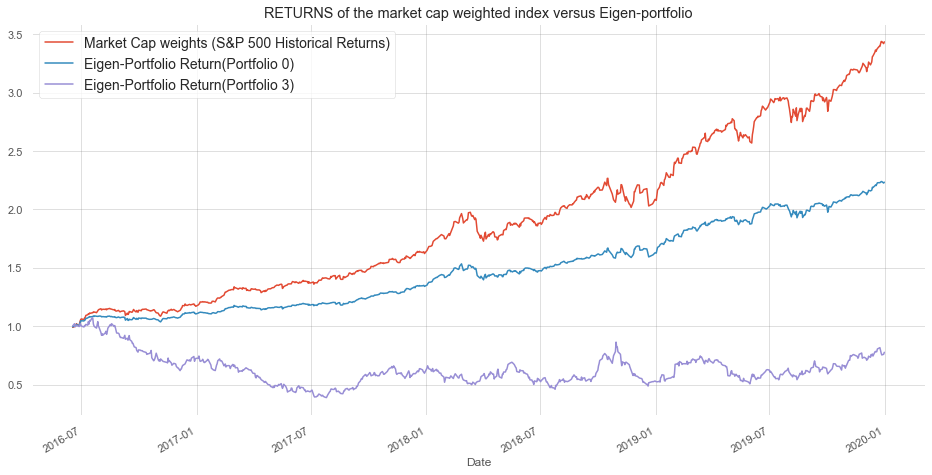

In [134]:
# Plot
df_plot = pd.DataFrame({
                        "Market Cap weights (S&P 500 Historical Returns)": eigen_portfolio_returns_market,
                        "Eigen-Portfolio Return(Portfolio 0)": eigen_portfolio_returns_p0,
                        "Eigen-Portfolio Return(Portfolio 3)": eigen_portfolio_returns_p3},
                       index = X_Test.index)
    
np.cumprod(df_plot + 1).plot(title = "RETURNS of the market cap weighted index versus Eigen-portfolio",
                                 figsize = (16, 8)
                                )
plt.show()
# the market cap weights is dervied by manually normalizing the 30 components in our portfolio
# if you see closely the first principal component eigen portfolio trend mimics the variance of the market cap weights
# the first principal component can be seen behaving like the market

In [135]:
# The red line shows the historical returns for the past 5 years,
#which is upwards sloping. The Eigen portfolio which is equally weighted will 
# therefore be unable to outperform the market.
#However, the trend of s&p 500 remaining in a upwards trajectory for the next 5 years 
#may change due to policy changes such as low interest rate by the Federal Reserve. 
#Hence, the equally weighted portfolio may actually have a chance to outperform the 
#market portfolio given a change in market regime. 